train.csv :
·      area_type: The type of the house area feature 'total_sqft' specifies.
·      availability: The availability date or availability status of the property.
·      location: The locality of the property in Bengaluru city.
·      size: The size of the housing property in BHK (or Bedrooms etc.,).
·      society: The name of the Apartment. This name is encrypted for confidentiality.
·      total_sqft: The 'area_type' area of the property.
·      bath: Number of bathrooms available in the house.
·      balcony: Number of balcony/balconies the house has.
·      price: Price of the housing property in Lakhs. (target feature)
 
The `test.csv` dataset contains similar information to train.csv but does not disclose the “price” feature. The price has to be predicted through your model.
 
avg_rent.csv :
·      location : The locality of the property in the bengaluru city.
·      avg_2bhk_rent : Average rent of two BHK flat in that location
 
 
dist_from_city_centre.csv : 
·      location : The locality of the property in the bengaluru city.
·      dist_from_city : Distance of the location from city center

In [ ]:
# NEW INSTALLATIONS NEEDED FOR THIS WORKBOOK
# pip install geopy
# pip install geopandas
# pip install geocoder
# pip install xgboost

In [1]:
import numpy as np
import re
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
matplotlib.rcParams['font.family'] = "Arial"

%matplotlib inline
import collections
import itertools
import scipy.stats as stats
from scipy.stats import norm
from scipy.special import boxcox1p
import statsmodels
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
#print(statsmodels.__version__)
from sklearn.preprocessing import scale, StandardScaler, RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, StratifiedKFold, RandomizedSearchCV
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, LinearRegression, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.utils import resample
from sklearn import preprocessing

from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from itertools import combinations
import geocoder
import math
import geopandas as gpd
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error

import warnings

warnings.filterwarnings("ignore")

### FUNCTIONS needed for processing data after reading

In [2]:
def get_geocoder(location_string):
    result = geocoder.arcgis(location=location_string)
    if result.ok:
        lat, lon = result.latlng
        return str(lat).replace('-','') + "-" + str(lon).replace('-','')
    else:
        return np.nan
        # raise Exception(f"I have gotten a bad result for {location_string} :-(")


def get_geocode(location_string):
    locator = Nominatim(user_agent="myGeocoder")
    print(location_string)
    if location_string is np.nan :
        pass
    else:
        location = locator.geocode((location_string + ", Bangalore, Karnataka, India").lower().strip().replace('  ', ' '))
        if location is None:
            return get_geocoder(location_string)
        else:
            return str(location.latitude).replace('-','') + "-" + str(location.longitude).replace('-','')

def fill_empty_rows(df):
    uniq_loc_missing_lat = df.loc[df['loc_lat']==""]['location'].unique()
    uniq_loc_missing_long = df.loc[df['loc_long']==""]['location'].unique()
    unique_loc_missing_dir = df.loc[df['dir_from_centre']==""]['location'].unique()
    location_coord_dict = {}
    loc_direction_dict = {}
    for location in uniq_loc_missing_lat:
        location_coord_dict[location] = get_geocode(location)
    for location in uniq_loc_missing_long:
        location_coord_dict[location] = get_geocode(location)
    for location in unique_loc_missing_dir:
        loc_direction_dict[location] = get_direction_from_city_centre(get_geocode(location))
        
    for index, rows in df.loc[df['loc_lat']==""].iterrows():
        if str(df.loc[index, 'location']).lower() == "nan":
            pass
        else:
            if location_coord_dict.get(df.loc[index, 'location']) is np.nan:
                df.loc[index, 'loc_lat'] = np.nan
            else:
                df.loc[index,'loc_lat'] = location_coord_dict[df.loc[index,'location']].split("-")[0]
    
    for index, rows in df.loc[df['loc_long']==""].iterrows():
        if str(df.loc[index, 'location']).lower() == "nan":
            pass
        else:
            if location_coord_dict.get(df.loc[index, 'location']) is np.nan:
                df.loc[index, 'loc_long'] = np.nan
            else:
                df.loc[index,'loc_long'] = location_coord_dict[df.loc[index,'location']].split("-")[1]
    
    for index, rows in df.loc[df['dir_from_centre']==""].iterrows():
        if str(df.loc[index, 'location']).lower() == "nan":
            pass
        else:
            if loc_direction_dict.get(df.loc[index, 'location']) is np.nan:
                df.loc[index, 'dir_from_centre'] = np.nan
            else:
                df.loc[index,'dir_from_centre'] = loc_direction_dict[df.loc[index,'location']]   
    
    print(f"Still {len(df.loc[df['loc_lat']==''])} rows dont have Location latitudes coordinates.")
    print(f"Still {len(df.loc[df['loc_long']==''])} rows dont have Location longitudes coordinates.")
    print(f"Still {len(df.loc[df['dir_from_centre']==''])} rows dont have Directions.")
    return df
        

def fill_geo_codes(df):
    unique_locations_train = df['location'].unique()
    loc_lat_long = {}
    loc_direction_from_city_centre = {}
    for location in unique_locations_train:
        geocode_location = get_geocode(location)
        direction = ''
        if geocode_location is np.nan:
            direction = np.nan
        else:
            direction = get_direction_from_city_centre(geocode_location)
        loc_lat_long[location] = geocode_location
        loc_direction_from_city_centre[location] = direction
    df["loc_lat"] = ""
    df["loc_long"] = ""
    df["dir_from_centre"] = ""
    for index, row in df.iterrows():    
        if str(df.loc[index, 'location']).lower() == "nan":
            pass
        else:
            if loc_lat_long.get(df.loc[index, 'location']) is np.nan:
                df.loc[index, 'loc_lat'] = np.nan
                df.loc[index, 'loc_long'] = np.nan
            elif loc_lat_long.get(df.loc[index, 'location']):
                df.loc[index, 'loc_lat'] = loc_lat_long[df.loc[index, 'location']].split("-")[0]
                df.loc[index, 'loc_long'] = loc_lat_long[df.loc[index, 'location']].split("-")[1]
            if loc_direction_from_city_centre.get(df.loc[index, 'location']) is np.nan:
                df.loc[index, 'dir_from_centre'] = np.nan
            elif loc_direction_from_city_centre.get(df.loc[index, 'location']):
                df.loc[index, 'dir_from_centre'] = loc_direction_from_city_centre[df.loc[index, 'location']]
    return df
    


def calcBearing (lat1, long1, lat2, long2):
    dLon = (long2 - long1)
    x = math.cos(math.radians(lat2)) * math.sin(math.radians(dLon))
    y = math.cos(math.radians(lat1)) * math.sin(math.radians(lat2)) - math.sin(math.radians(lat1)) * math.cos(math.radians(lat2)) * math.cos(math.radians(dLon))
    bearing = math.atan2(x,y)   # use atan2 to determine the quadrant
    bearing = math.degrees(bearing)

    return bearing

def calcNSEW(lat1, long1, lat2, long2):
    points = ["north", "north east", "east", "south east", "south", "south west", "west", "north west"]
    bearing = calcBearing(lat1, long1, lat2, long2)
    bearing += 22.5
    bearing = bearing % 360
    bearing = int(bearing / 45) # values 0 to 7
    NSEW = points [bearing]

    return NSEW
    
    
def get_direction_from_city_centre(received_geocode):
    central_bang_lat = 12.972442
    central_bang_long = 77.580643
    if received_geocode == "nan" or received_geocode is None:
        return np.nan
    elif received_geocode is np.nan:
        return np.nan
    else:
        print(received_geocode)
        received_lat = float(received_geocode.split('-')[0])
        received_long = float(received_geocode.split('-')[1])
    return calcNSEW(central_bang_lat, central_bang_long, received_lat, received_long)
    

# TRIAL RUN
get_geocode("Amco Colony")

# Replace these regions in train and test data with the corresponding regions, so that we can get the location coordinates
# devasthanagalu : varthur
# javarandoddi : rr nagar
# volagerekallahalli : Chikkadasarahalli

Amco Colony


'32.78179000000006-95.68801999999994'

In [948]:
# EITHER THIS TO BE RUN OR THE BELOW CELL FOR READING THE DATA, BUT NOT BOTH TOGETHER
df = pd.read_csv("train.csv")
df_rent = pd.read_csv("avg_rent.csv")
df_dist = pd.read_csv("dist_from_city_centre.csv")
df_test = pd.read_csv("test.csv")

Electronic City Phase II
12.8468545-77.6769267
Chikka Tirupathi
12.8957681-77.8671014
Uttarahalli
12.9055682-77.5455438
Lingadheeranahalli
13.00129000000004-77.47907000000004
Kothanur
13.0613601-77.6493895
Whitefield
12.9696365-77.7497448
Old Airport Road
12.9583828-77.6663946
Rajaji Nagar
12.9995223-77.5505328
Marathahalli
12.9552572-77.6984163
Gandhi Bazar
12.9482767-77.5707802
7th Phase JP Nagar
12.912432-77.5759515
Gottigere
12.8565317-77.5877237
Sarjapur
12.932266649999999-77.68374728308987
Mysore Road
12.9467026-77.5300705
Bisuvanahalli
13.237580000000037-77.56019000000003
Raja Rajeshwari Nagar
12.858390000000043-80.18606000000005
Ramakrishnappa Layout
12.9778951-77.5164792
Manayata Tech Park
13.0454341-77.6267753
Kengeri
12.9176571-77.4837568
Binny Pete
12.966750000000047-77.55946000000006
Thanisandra
13.054713-77.6339258
Bellandur
12.9279555-77.6807658
 Thanisandra
13.054713-77.6339258
Mangammanapalya
12.8957595-77.64570119478071
Electronic City
12.848759900000001-77.6482529582

13.0321435-77.5734663
Banashankari3rd stage bigbazar
12.926630000000046-77.55083000000008
Bagalur Main Road
12.961005674287733-77.59082686157839
Kodihalli
12.9624481-77.6463772
Narayanapura
13.3397035-77.763495
Binny Mills Employees Colony
29.672660000000064-75.56749000000008
Bannerghatta Road
12.8905219-77.598149
Hennur
13.0258087-77.6305067
5th Phase JP Nagar
12.9118678-77.5765347
Kodigehaali
13.065830000000062-77.57217000000009
Gopalapura
13.1331985-77.6874906
Billekahalli
12.90008000000006-77.60432000000003
Jalahalli
13.0464531-77.5483803
Mahadevpura
12.9936177-77.6856673
Anekal
12.799122-77.68060437921743
Hoodi Circle, 
12.99196225-77.7154228382988
Sompura
12.8778283-77.4972385
Ashirvad Colony
26.20646000000005-78.14620000000008
Dodda Nekkundi
12.96577205-77.70809738675412
K N Extension
13.021730000000048-77.55721000000005
Hosur Road
12.9527111-77.6052566
Battarahalli
13.020020000000045-77.70975000000004
Gokula Extension
13.041120000000035-77.54829000000007
Kamakshipalya
12.982361

13.011600000000044-77.67784000000006
Kempapura
13.1311691-77.8020446
BTM 1st Stage
12.916961-77.6089475
Kariyammana Agrahara
12.9380248-77.6880886
Hessarghatta
13.048425850000001-77.50762318993515
Binnamangala
12.9839881-77.6416769
Suraksha Nagar
21.149690000000078-78.99374000000006
Lakshmi Layout
12.95569425-77.72645097106465
Iblur Village
14.68073000000004-74.88036000000005
Kadugondanahalli
13.0207029-77.6215464
Basava Nagar
12.9854607-77.58874456879997
2nd Block Hrbr Layout
13.021360000000072-77.64321000000007
Ananth Nagar
12.954080000000033-77.54135000000008
Canara Bank Layout
13.068572-77.5783554
Narasapura
13.2043595-77.3245045
Manjunath Nagar
12.9939514-77.5480532
Basapura
12.8655289-77.6471089
Channasandra
12.9804938-77.7683853
Singena Agrahara
12.8383527-77.7153121
Sector 1 HSR Layout
12.9154717-77.6482844
Mango Garden Layout
12.90551000000005-77.64735000000007
Kacharakanahalli
12.9957647-77.814568
Bidere Agarahara, Behind Safal market
25.05737000000005-85.55366000000004
Griha

13.09292000000005-77.54819000000003
Chokkasandra
13.1879708-77.9010899
Panduranga Nagar
12.8930758-77.5961351
Sri Venkateshpura Layout
12.99428000000006-77.48959000000008
Jakkur Plantation
13.0834599-77.5980019
Sir M V Nagar
13.019270000000063-77.67602000000005
Bikasipura
12.893550000000062-77.56173000000007
Basaveshwara Nagar Yelahanka
12.986740000000054-77.54389000000003
1st Block Koramangala
12.9275886-77.6308832
Hoskote
13.073014-77.7921381
Attiguppe
12.9628474-77.5291685
Srirampuram
12.987910000000056-77.56249000000008
Yemlur
12.946651450000001-77.67606545972268
Race Course Road
12.9844722-77.5880577
Gkvk Layout
13.0705725-77.5781428
St. John's Road
12.9886729-77.6172469
Doopanahalli
12.9674584-77.6396382
Doddaballapur
13.2929583-77.5431463
Sathanur
13.1279084-77.646629
Ramamohanapuram
12.997460000000046-77.56485000000004
kanakapura road
12.8850369-77.5538695
Kaveri Nagar
13.0386319-77.646528
Sundar Ram Shetty Nagar
12.895160000000033-77.60879000000006
Kirloskar layout, Basaveshwa

39.917520000000025-77.79785999999996
Ckikkakammana Halli
11.766670000000033-41.783330000000035
Banashankari 2nd Stage
12.9245925-77.5645639
Munivenkatppa Layout
13.041000000000054-77.62243000000007
Kamala Nagar
12.98770805-77.59697786817775
Kumarapalli
18.01496000000003-79.57774000000006
Marenahalli
12.9182594-77.5916651
Nagawara Junction
13.0454341-77.6267753
Maithri Layout
12.9848621-77.7559192
Raja Rajeshwari Nagar 5th Stage
12.958926506436304-80.19832321652122
Nanjappa Garden
13.0234077-77.6504121
Vayunandana Layout
22.34505000000007-85.29885000000007
Geetanjali Layout
12.9359877-77.69769541249171
Kenchenhalli
12.927260000000047-77.51198000000005
EPIP AREA, WHITEFIELD
53.54788737200005-2.2935166639999807
1st Stage Domlur
12.959142-77.6377909
RMV extension stage 2, rmv extension
13.048400049120374-77.57540006543294
Kalhalli
11.964750000000038-76.54622000000006
Hadosiddapura
12.893932549999999-77.7080199700685
Vijaya Bank Colony
13.0155749-77.6592222
Lakkasandra
12.9432228-77.5997061

12.930774-77.5968998
Nagarbhavi  BDA Complex
12.9793561-77.5105425
Gidada Konnenahalli
12.974030000000027-77.49163000000004
Rahat Bagh
17.38870000000003-78.49448000000007
Escorts Colony
13.1023158-77.5860665
asha township, off hennur road
13.064800000000048-77.67580000000004
1A Block Koramangala
12.933232-77.6254669
Near International Airport
46.93551000000008-28.93524000000008
NTI Layout
13.077300000000037-77.55626000000007
Fraser town
43.75927000000007-83.97750999999994
Dasappa Layout
12.9601375-77.595942
Sonam Layout
22.34505000000007-85.29885000000007
CR Layout
45.07134000000008-108.23122999999998
BTM 4th Stage
12.916360300000001-77.60473305
Arekempanahalli
12.9446007-77.594691
Chamundi Nagar
12.9780257-77.6439707
MRCR Layout
22.34505000000007-85.29885000000007
Shettihalli
12.7528354-77.7305926
Gangondanahalli
13.0221902-77.4675283
Ullal Road
12.9514665-77.4923596
Hullahalli
12.8267311-77.6170537
Jagajyothi layout
12.94297000000006-77.49404000000004
Lakkasandra Extension
31.9619200

13.023855051705178-77.69519994744441
Phase 1 Kammasandra
12.83907000000005-77.65912000000003
Deepanjali Nagar
12.943877650000001-77.53992510658712
SARJAPUR BAGALUR ROAD
13.121610000000032-77.61352000000005
B Y Raveshwara Nagar
13.09785000000005-77.40400000000005
KEB Colony
13.0359923-77.5749695
HOSUR RMAIN ROAD
15.345186835003277-75.14166952503273
Konappana Agrahara
12.8528618-77.668169
Rajasree Layout
13.063010000000077-77.63154000000003
Vinayaka Layout
12.9631421-77.5086468
Thirumalashettyhally
12.988390000000038-77.78248000000008
Bharathnagar
18.100130000000036-78.84614000000005
5th Block Jayanagar
12.9194605-77.58332110317872
Jayanagar, 
12.9236698-77.5783575
Asthagrama Layout
12.983780000000024-77.53320000000008
Rajarajesheari nagar
17.47004000000004-78.35268000000008
Millers Road
12.9934802-77.5956667
2nd Block Hbr Layout
13.0260911-77.628483
Madavara
13.0531988-77.4729679
Dwaraka Nagar
12.9338561-77.5391101
Garebhavipalya
12.892750000000035-77.63744000000008
Neelamangala
12.8570

12.914506-77.5604592
Kundalahalli
12.9684441-77.7187843
Lakshmiamma Garden
12.955740000000048-77.59921000000008
Gunjur
13.4279345-77.5131493
Guni Agrahara
13.096250000000055-77.52618000000007
Ganga Nagar
13.0232471-77.5883569
BEL Road
13.0542507-77.5496786
Madavara
13.0531988-77.4729679
Cooke Town
13.0027852-77.624747
Nagarbhavi
12.95961755-77.51126721318181
Kasturi Nagar
13.0044979-77.6603231
Babusapalaya
13.0283523-77.650469
Bharathi Nagar
13.13847625-77.62049897098888
Balagere
12.9377243-77.7280705
Kudlu
12.8889126-77.6555716
Gottigere
12.8565317-77.5877237
Akash Nagar
29.951680000000067-76.83705000000003
Seetharampalya
12.98241125-77.71319024278168
Singasandra
12.88027485-77.65475374894244
Cambridge Layout
12.9701231-77.6277757
3rd Phase JP Nagar
12.9116311-77.5974042
5th Phase JP Nagar
12.9118678-77.5765347
cooketown
40.03309000000007-77.30474999999996
Jakkur
13.0784743-77.6068938
5th Stage BEML Layout
12.9083587-77.5209058
Shauhardha Layout
22.34505000000007-85.29885000000007
Kav

12.9558969-77.7405826
Shivaji Nagar
12.9801559-77.6023714
Gulimangala
12.855280449999999-77.69590772159883
Nagashetty Halli
13.044020000000046-77.57407000000006
Devasandra Extension
31.961920000000077-91.80323999999996
Channasandra Layout
12.987127-77.7537448
Kamala Nagar
12.98770805-77.59697786817775
Suraksha Nagar
21.149690000000078-78.99374000000006
Sathya Sai Layout
12.9888515-77.7183672
Binny Pete
12.966750000000047-77.55946000000006
Kereguddadahalli
13.078950000000077-77.51662000000005
Raja Rajeshwari Nagar 5th Stage
12.958926506436304-80.19832321652122
Ganesha Block
13.02534165-77.60195559210791
ITPL
12.9845687-77.73766474151809
Banagiri Nagar
12.92295675-77.55867491163966
BHEL Layout
12.9184375-77.5092496
Amblipura
12.913530000000037-77.67156000000006
Dodda Banaswadi
13.014380000000074-77.65215000000006
Konena Agrahara
12.9586061-77.6623373
GD Layout
22.34505000000007-85.29885000000007
Lakshminarayana Pura
12.827890000000025-76.90970000000004
Sunkan palya
13.173490000000072-77.

12.879350000000045-77.62198000000006
Gowdanapalya
12.909680000000037-77.55675000000008
Tasker Town
12.9801622-77.605818
manyata
13.0546437-77.62273981692556
Badavala Nagar
19.056260000000066-74.82070000000004
Bhuvaneswari Nagar
13.054757649999999-77.60243731962916
RWF West Colony
13.10176000000007-80.21110000000004
Langford Town
12.957998-77.6037312
 Mysore Highway
13.1908778-77.6457522
Doddathoguru
12.8529125-77.6556155
LIC Colony
12.9690711-77.6542086
Glass Factory Layout
13.0339172-77.622515
Gaurava Nagar
23.35707000000008-75.05506000000008
Siddapura
12.9542596-77.7309743
Kumbalgodu
13.072610000000054-77.50321000000008
Mallappa Layout
13.015940000000057-77.72120000000007
Ullal Road
12.9514665-77.4923596
Dodsworth Layout
12.9707696-77.744557
Vinayak Nagar
32.76150000000007-74.81281000000007
Silk Board
12.9167972-77.6235628
Ankappa Layout
12.910380000000032-77.55334000000005
Doopanahalli
12.9674584-77.6396382
3rd Stage Raja Rajeshwari Nagar
12.858390000000043-80.18606000000005
Dominic

In [ ]:
# Filling the geocodes in Train and Test data
df = fill_geo_codes(df)
df_test = fill_geo_codes(df_test)

In [949]:
# Filling the empty rows of Geocodes in Train and Test data
df = fill_geo_codes(df)
df_test = fill_geo_codes(df_test)

nan
nan
nan
Still 1 rows dont have Location latitudes coordinates.
Still 1 rows dont have Location longitudes coordinates.
Still 1 rows dont have Directions.
Still 0 rows dont have Location latitudes coordinates.
Still 0 rows dont have Location longitudes coordinates.
Still 0 rows dont have Directions.


In [52]:
# Once COORDINATES ARE ALREADY WRITTEN use the modified CSV from start everytime
df = pd.read_csv("train_with_loc_coordinates.csv")
df_rent = pd.read_csv("avg_rent.csv")
df_dist = pd.read_csv("dist_from_city_centre.csv")
df_test = pd.read_csv("test_with_loc_coordinates.csv")
df.head()

,Unnamed: 0,ID,area_type,availability,location,size,society,total_sqft,bath,balcony,price,loc_lat,loc_long,dir_from_centre
0,0,0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07,12.846854,77.676927,south east
1,1,1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00,12.895768,77.867101,east
2,2,2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00,12.905568,77.545544,south west
3,3,3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00,13.001290,77.479070,west
4,4,4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00,13.061360,77.649389,north east


### FUNCTIONS needed for processing the data

In [53]:
# GLOBAL VARIABLES
set_locations_train_data = set(df['location'].unique())
set_locations_test_data = set(df_test['location'].unique())
set_location_dist = set(df_dist['location'].unique())
set_location_in_both_train_test_data = set_locations_test_data.intersection(set_locations_train_data)

def split_size(df, index, size):
    df.loc[index, 'room_count'] = str(size).split()[0]
    if str(size).split()[1] == "BHK":
        df.loc[index, 'hall'] = 1
        df.loc[index, 'kitchen'] = 1
    elif str(size).split()[1] == "RK":
        df.loc[index, 'hall'] = 0
        df.loc[index, 'kitchen'] = 1
    else:
        df.loc[index, 'hall'] = 0
        df.loc[index, 'kitchen'] = 0

def return_in_sq_ft(value, units):
    units = units.lower()
    value=float(value)
    if units=="grounds":
        return value*2400.352024
    elif units=="perch":
        return value*272.25
    elif units=="acres":
        return value*43560.00001
    elif units=="guntha":
        return value*1089
    elif units=="sq.yards":
        return value*9.000000878
    elif units=="sq.meter":
        return value*10.76391042
    elif units=="cents":
        return value*435.56
    else:
        print(f"{units} not FOUND")

def units_in_sq_ft(value):
    if re.search(r'[a-zA-Z]',value) != None:        
        s_arr = re.findall(r'\d+[.]?\d*|[A-Za-z.]+', value)
        return return_in_sq_ft(s_arr[0], "".join(s_arr[1:]))
    elif value.find("-")!=-1:
        return (float(value.split("-")[0])+float(value.split("-")[1]))/2
    else:
        return float(value)
        

def min_max_scale(x, min_val, max_val):
    return (x - min_val)/(max_val - min_val)

def get_dist(location):
    if location in df_dist['location'].unique():
        return df_dist.loc[df_dist['location'] == location]['dist_from_city'].values[0]
    else:
        return df_dist['dist_from_city'].median()

# Erasing the outliers from each group of locations
def remove_pps_outliers(df):
    df_out=pd.DataFrame()
    for key,subdf in df.groupby('location'):
        m=np.mean(subdf.price_per_square_ft)
        st=np.std(subdf.price_per_square_ft)
        reduced_df=subdf[(subdf.price_per_square_ft>=(m-3*st))& (subdf.price_per_square_ft<=(m+3*st))]
        df_out=pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out


def plot_multiple_size_with_price(size_1, size_2, location, df):
    bhk_first = df[(df['location']==location) & (df['room_count']==size_1)]
    big_bhk_first = bhk_first[bhk_first['room_size']==1]
    small_bhk_first = bhk_first[bhk_first['room_size']==0]
    bhk_second = df[(df['location']==location) & (df['room_count']==size_2)]
    big_bhk_second = bhk_second[bhk_second['room_size']==1]
    small_bhk_second = bhk_second[bhk_second['room_size']==0]
    matplotlib.rcParams['figure.figsize'] = (15,10)
    plt.scatter(big_bhk_first.total_sqft,big_bhk_first.price,color='blue',label=str(size_1)+" BHK", s=50)
    plt.scatter(big_bhk_second.total_sqft,big_bhk_second.price,marker='+',color='red',label=str(size_2)+" BHK", s=50)
    
    plt.xlabel("Total Square Feet Area - Big HOUSES")
    plt.ylabel("Price (Lakh Indian Rupees)")
    plt.title(location)
    plt.legend()
    plt.show()

def remove_irregularly_priced_houses(df):
    exclusion_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        for size, size_df in location_df.groupby(['room_count']):
            bhk_stats[size] = {
                'mean': np.mean(size_df.price_per_square_ft),
                'std': np.std(size_df.price_per_square_ft),
                'count': size_df.shape[0]
            }
        for size, size_df in location_df.groupby('room_count'):
            stats = bhk_stats.get(size-1)
            if stats and stats['count'] >= 5:
                exclusion_indices = np.append(exclusion_indices, size_df[size_df.price_per_square_ft<(stats['mean'])].index.values)
    return df.drop(exclusion_indices, axis='index')

def find_best_model_using_gridsearchcv(X, y):
    algos = {
        'linear_regression' : {
            'model': LinearRegression(),
            'params': {
                'normalize': [True, False]
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [0.1, 0.3],
                'selection': ['random', 'cyclic']
            }
        },
        'ridge': {
            'model': Ridge(),
            'params': {
                'alpha': [0.7, 0.9]
            }
        },
        'random_forest': {
            'model': RandomForestRegressor(),
            'params': {
                'n_estimators': [300, 500, 600], 'max_depth': [20, 25], 
            }
        },
        'xgboost': {
            'model': XGBRegressor(),
            'params': {
                'n_estimators': [100, 150], 
            }
        }

    }
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs =  GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores,columns=['model','best_score','best_params'])

In [54]:


def preprocess_data(df, data_type:str="train"):
    unique_location_count = df.groupby("location")["location"].agg("count").sort_values(ascending = False)
    unique_location_count_10 = unique_location_count[unique_location_count <= 10]
    # df["location"] = df["location"].apply(lambda x : "other" if (x in unique_location_count_10) or (x not in set_location_in_both_train_test_data) else x)
    
    df['availability'] = df['availability'].apply(lambda x: 1 if x=="Ready To Move" else 0)
    
    df['location'] = df['location'].apply(lambda x: str(x).lower().strip().replace('  ', ' '))
    
    sns.scatterplot(x=df['size'], y=df.balcony)
    plt.show()
    
    df.drop(columns=["ID", "society", "Unnamed: 0"], axis=1, inplace=True)
    
    # Replacing 1 NaN in location with mode of the dataset
    df['location'] = df['location'].fillna('whitefield')
    
    df['size'] = df['size'].fillna('2 BHK')

    # Creating 3 additional columns
    df['hall'] = np.nan
    df['kitchen'] = np.nan
    df['room_count'] = np.nan
    
    for index, row in df.iterrows():
        split_size(df, index, df.loc[index, 'size'])
    
    df[['price','room_count','loc_lat','loc_long']] = df[['price','room_count','loc_lat','loc_long']].astype(float)
    
    # For all rows where room_count is greater than 10, lets drop them
    # Also our Test data has only rooms till 10.
    df = df[df['room_count']<=10]
    df = df[df['size']!='1 RK']
    
    median_bath_df = pd.DataFrame(df.groupby('size')['bath'].median())
    
    # Filling the NaN values in bath with corresponding median for the respective room size
    for index, row in df.iterrows():
        if np.isnan(df.loc[index, 'bath']):
            df.loc[index, 'bath'] = median_bath_df.loc[df.loc[index,'size']].values[0]
    
    # Replacing all the NaN values in balcony witht the median of the subgroup based on number of rooms
    balcony_df = pd.DataFrame(df.groupby('size')['balcony'].median())
    balcony_df.fillna(0, inplace=True)
    
    for index, row in df.iterrows():
        if np.isnan(df.loc[index, 'balcony']):
            df.loc[index, 'balcony'] = balcony_df.loc[df.loc[index,'size']].values[0]
    
    df["total_sqft"] = df["total_sqft"].apply(units_in_sq_ft)
    
    # Dropping columns
    df.drop(columns=["size"], inplace=True)
    
    if data_type == "train":
        df['price_per_square_ft'] = (df['price']*1000000)/df['total_sqft']
    df["sqft_per_bhk"] = df['total_sqft']/df['room_count']

    sns.histplot(df['bath'])
    plt.ylabel('Count')
    plt.show()

    df['room_size'] = np.nan

    for index, row in df.iterrows():
        if df.loc[index,'total_sqft']/df.loc[index,'room_count'] <= 300:
            df.loc[index, 'room_size'] = 0
        else:
            df.loc[index, 'room_size'] = 1

    sns.distplot(df_dist['dist_from_city'], kde=True)
    plt.vlines(x=df_dist['dist_from_city'].mean(), ymin=0, ymax=0.1, colors='r', linestyles='dashed')
    plt.vlines(x=df_dist['dist_from_city'].median(), ymin=0, ymax=0.1, colors='g', linestyles='dashed')
    plt.show()

    df['dist'] = df['location'].apply(get_dist)

    # Checking for outliers
    df_num = df.select_dtypes(include=np.number)
    # Dropping the categorical columns which are only numerically encoded
    df_num.drop(columns=["availability","hall","kitchen","room_size","loc_lat","loc_long"], inplace=True)
    fig,ax = plt.subplots(4,2, figsize=(15,20))
    for col, sub in zip(df_num, ax.flatten()):
        z=sns.boxplot(x=df_num[col], ax=sub, orient='h')
        z.set_xlabel(col, fontsize=10)
    plt.show()

    # Getting rid of the outliers from originally numeric column
    for col in df_num.columns:
        tempdata = df_num[col]
        q1,q3 = tempdata.quantile([0.25,0.75])
        IQR = q3-q1
        print(col, q1,q3, IQR)
        lr = q1-1.5*IQR
        ur = q3+1.5*IQR
        # Replacing the values 
        df_num[col] = df_num[col].apply(lambda x: x if x <= ur else ur)
        df_num[col] = df_num[col].apply(lambda x: x if x >= lr else lr)


    # Boxplot after getting rid of the outliers
    fig,ax = plt.subplots(4,2, figsize=(15,20))
    for col, sub in zip(df_num, ax.flatten()):
        z=sns.boxplot(x=df_num[col], ax=sub, orient='h')
        z.set_xlabel(col, fontsize=10)
    plt.show()

    df_1 = pd.concat([df.drop(columns=df_num.columns), df_num], axis=1)

    df_2=remove_pps_outliers(df_1)


    sns.distplot(df_2["sqft_per_bhk"], hist=True, kde=True, bins=100, color='blue', hist_kws={'edgecolor':'black'})
    plt.show()

    sns.distplot(df_2["total_sqft"], hist=True, kde=True, bins=100, color='blue', hist_kws={'edgecolor':'black'})
    plt.show()

    plot_multiple_size_with_price(1,2, "whitefield", df_2)
    plot_multiple_size_with_price(2,3, "whitefield", df_2)
    plot_multiple_size_with_price(3,4, "hebbal", df_2)

    df_3 = remove_irregularly_priced_houses(df_2)

    plot_multiple_size_with_price(2,3, "whitefield", df_3)

    df_3.dropna(inplace=True)

    if data_type == "train":
        # Creating a new column which maps every 1/2/3 room house with the location and have a average value about it.
        df_location_room_count_avg_rate = df_3.groupby(['location','room_count']).
        price = df_3["price"]
        df_3.drop(["price"], axis=1, inplace=True)

    # Ordinal Encoding to area_type
    ordinal_encoding_area_dict = {"Carpet  Area":1, "Built-up  Area":2, "Plot  Area":4, "Super built-up  Area":3}
    df_3['area_type'] = df_3['area_type'].map(ordinal_encoding_area_dict)

    X_num = df_3.select_dtypes(include=np.number)
    X_num.drop(columns=["availability", "area_type", "hall", "kitchen", "room_size"], inplace=True)
    out = price

    # Taking combination of 2 columns
    column_list = X_num.columns
    interactions = list(combinations(column_list, 2))
    interaction_dict = {}
    for interaction in interactions:
        print(interaction)
        int_2_cols = X_num.copy()
        int_2_cols['int'] = int_2_cols[interaction[0]] * int_2_cols[interaction[1]]
        lr = LinearRegression()
        lr.fit(int_2_cols, out)
        interaction_dict[lr.score(int_2_cols, out)] = interaction
    top_5 = sorted(interaction_dict.keys(), reverse = True)[:5]
    for interaction in top_5:
        print(interaction, interaction_dict[interaction])
    # Taking combination of 3 columns
    column_list = X_num.columns
    interactions = list(combinations(column_list, 3))
    interaction_dict = {}
    for interaction in interactions:
        int_2_cols = X_num.copy()
        int_2_cols['int'] = int_2_cols[interaction[0]] * int_2_cols[interaction[1]] * int_2_cols[interaction[2]]
        lr = LinearRegression()
        lr.fit(int_2_cols, out)
        interaction_dict[lr.score(int_2_cols, out)] = interaction
    top_5 = sorted(interaction_dict.keys(), reverse = True)[:5]
    for interaction in top_5:
        print(interaction, interaction_dict[interaction])
    # Taking combination of 4 columns
    column_list = X_num.columns
    interactions = list(combinations(column_list, 4))
    interaction_dict = {}
    for interaction in interactions:
        int_2_cols = X_num.copy()
        int_2_cols['int'] = int_2_cols[interaction[0]] * int_2_cols[interaction[1]] * int_2_cols[interaction[2]] * int_2_cols[interaction[3]]
        lr = LinearRegression()
        lr.fit(int_2_cols, out)
        interaction_dict[lr.score(int_2_cols, out)] = interaction
    top_5 = sorted(interaction_dict.keys(), reverse = True)[:5]
    for interaction in top_5:
        print(interaction, interaction_dict[interaction])

    # Adding the interaction column from above
    df_4 = df_3.copy()
    df_4['interaction'] = df_4['room_count'] * df_4['bath']

    # Dropping sqft_per_bhk as it will any way get dropped with lasso
    df_4.drop(columns=['sqft_per_bhk'], inplace=True)

    h_num = df_4[['bath', 'balcony', 'total_sqft', 'interaction', 'room_count', 'dist', 'loc_lat', 'loc_long']].reset_index(drop=True)
    std_scaler = StandardScaler()
    rob_scaler = RobustScaler()
    min_max_scaler = preprocessing.MinMaxScaler()
    scaled_f = pd.DataFrame(rob_scaler.fit_transform(h_num), columns=h_num.columns)
    dummies = pd.get_dummies(data=df_4.drop(columns=['location', 'bath', 'total_sqft', 'interaction', 'balcony', 'room_count', 'dist', 'loc_lat', 'loc_long']), columns=['dir_from_centre'], drop_first=True, prefix='', prefix_sep='')
    df_5 = pd.concat([scaled_f, dummies.reset_index(drop=True)], axis=1)
    return df_5, price

    

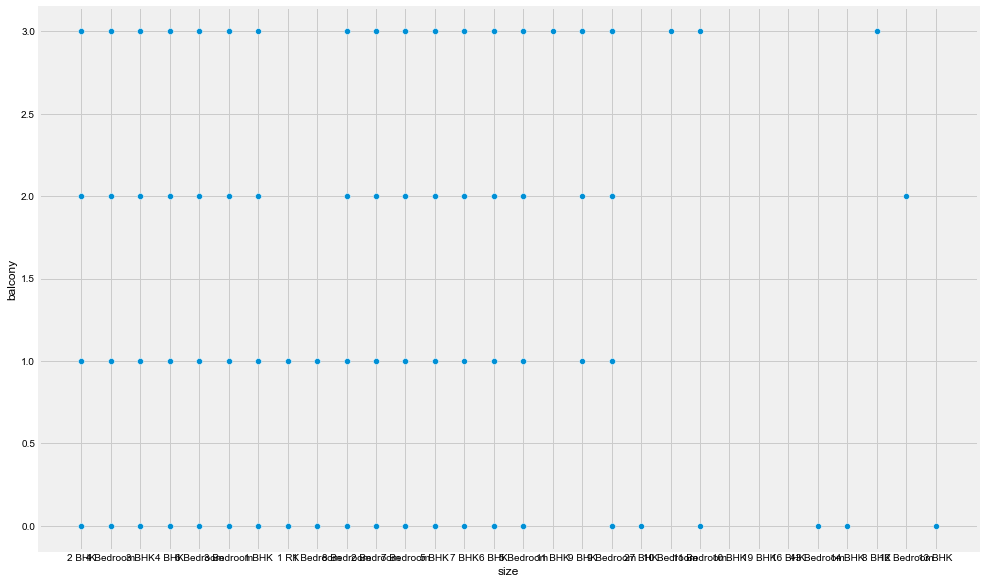

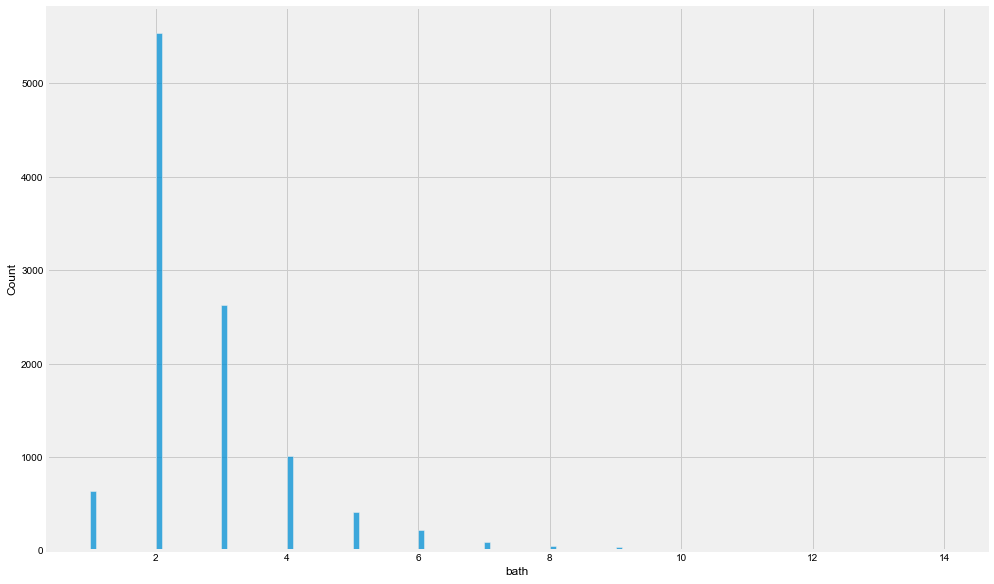

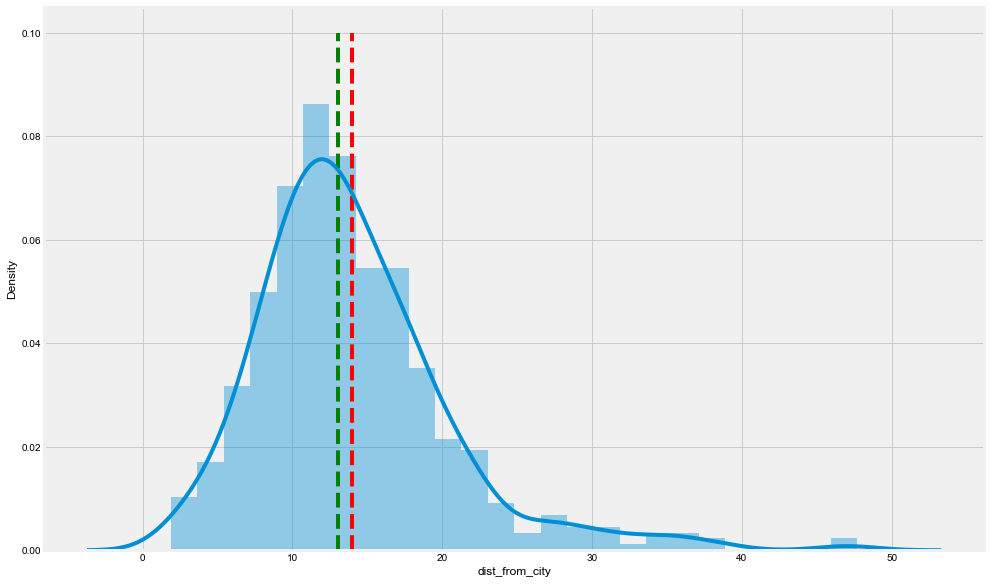

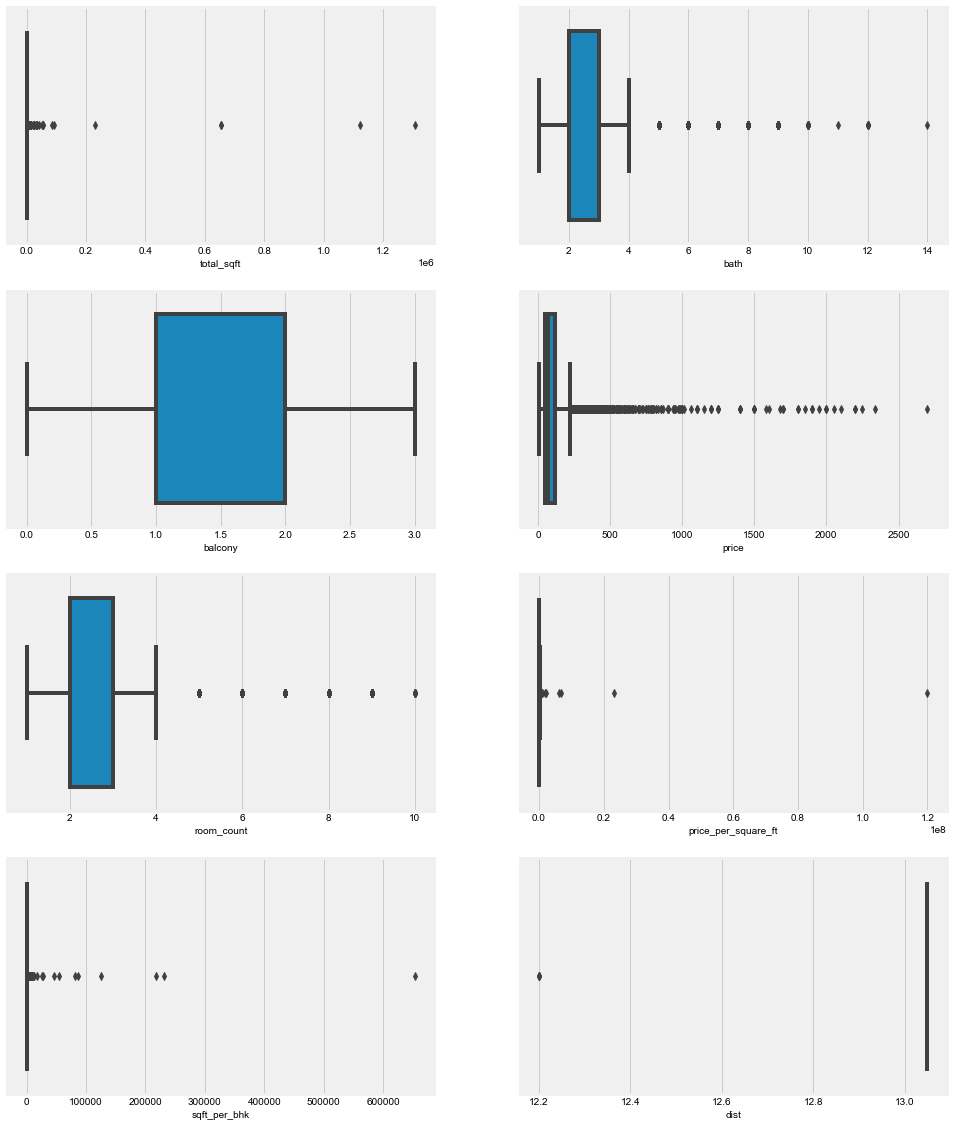

total_sqft 1100.0 1680.0 580.0
bath 2.0 3.0 1.0
balcony 1.0 2.0 1.0
price 50.0 120.0 70.0
room_count 2.0 3.0 1.0
price_per_square_ft 42709.17139346608 73335.68406205924 30626.51266859316
sqft_per_bhk 475.0 626.5 151.5
dist 13.05 13.05 0.0


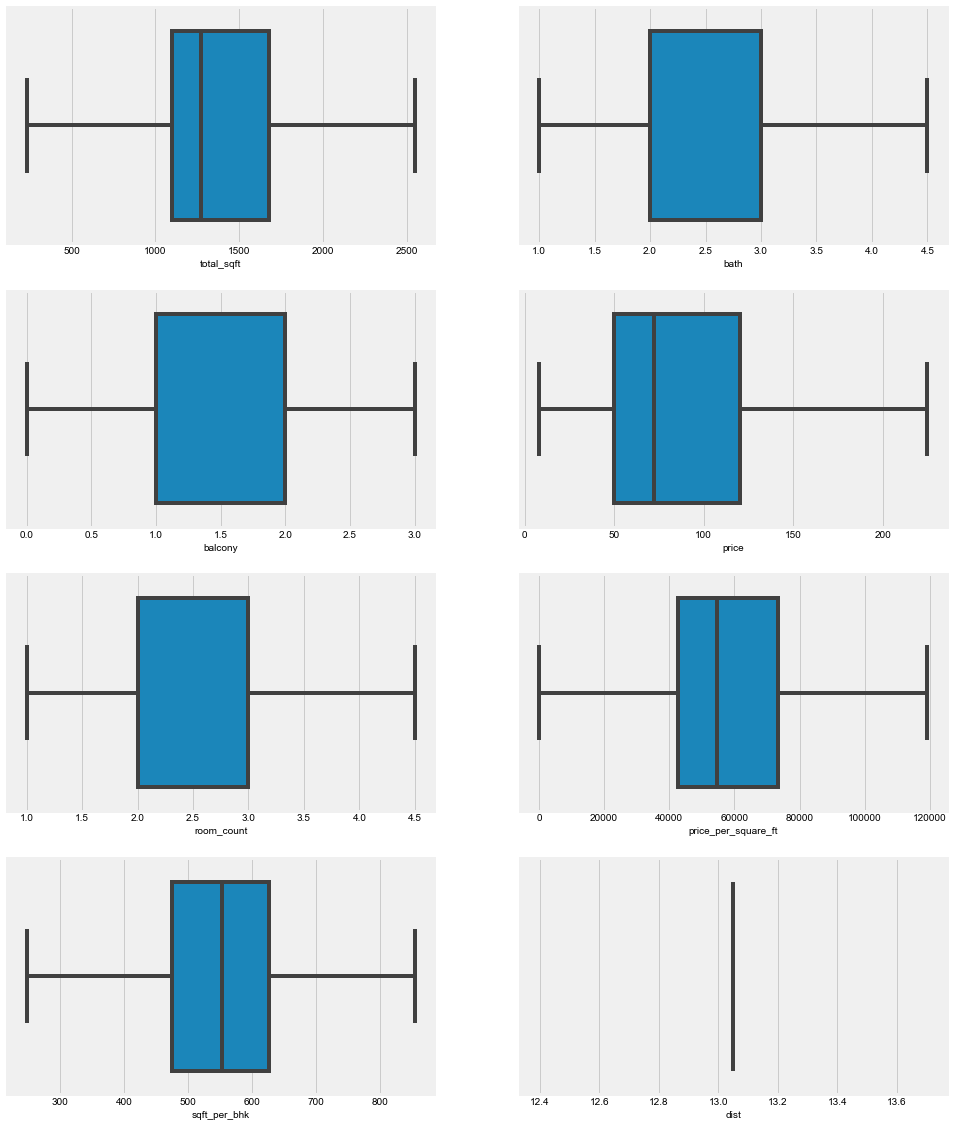

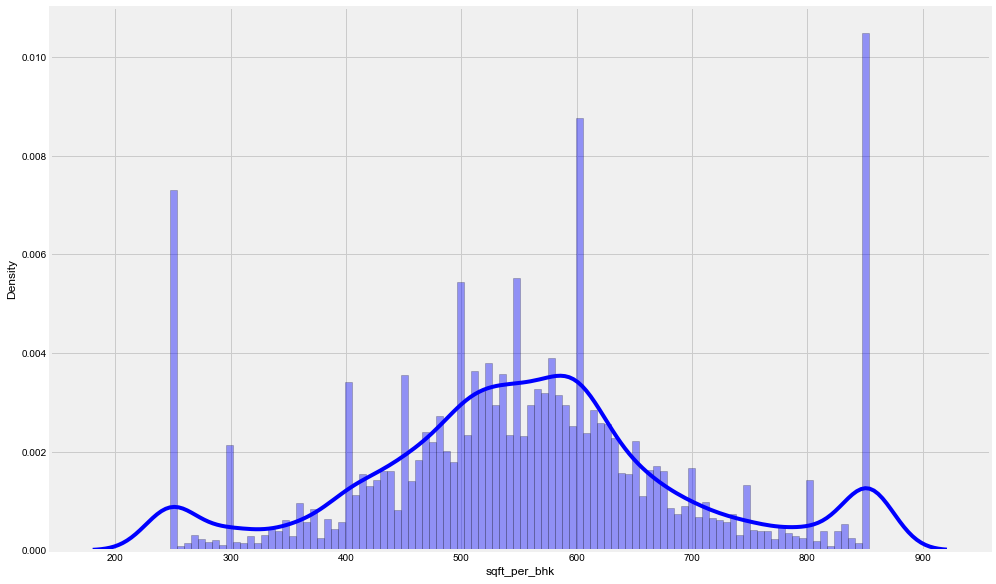

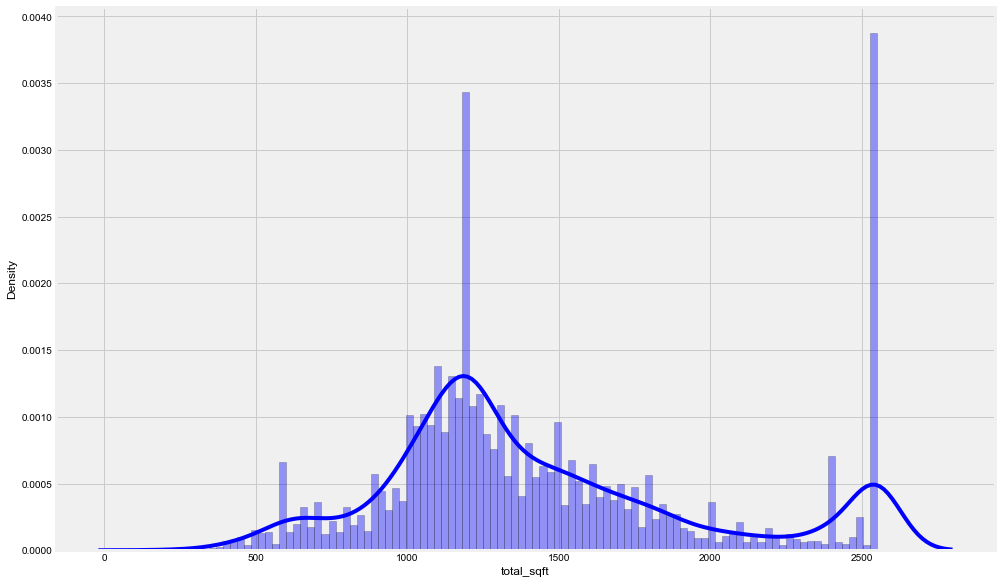

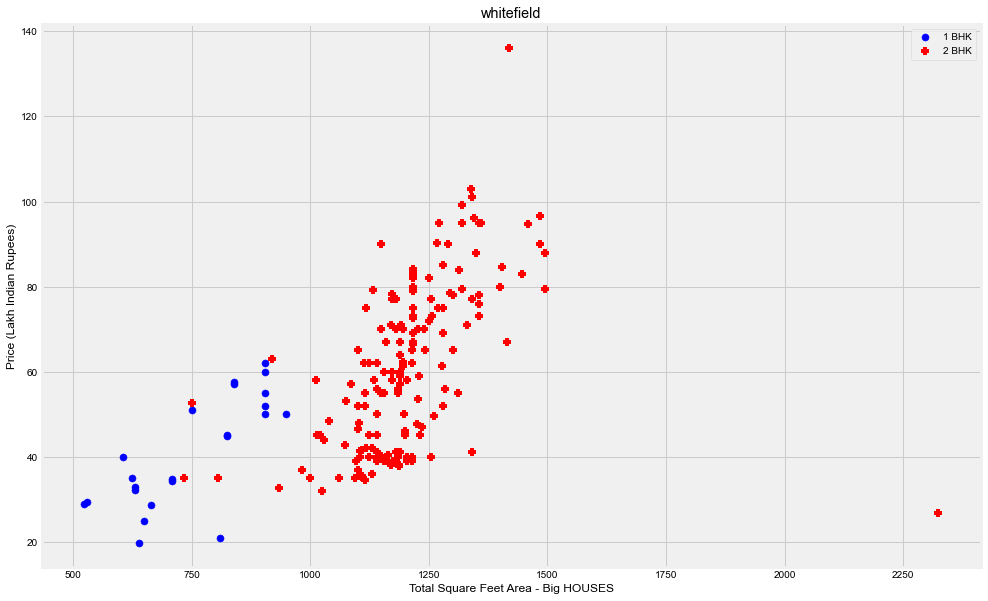

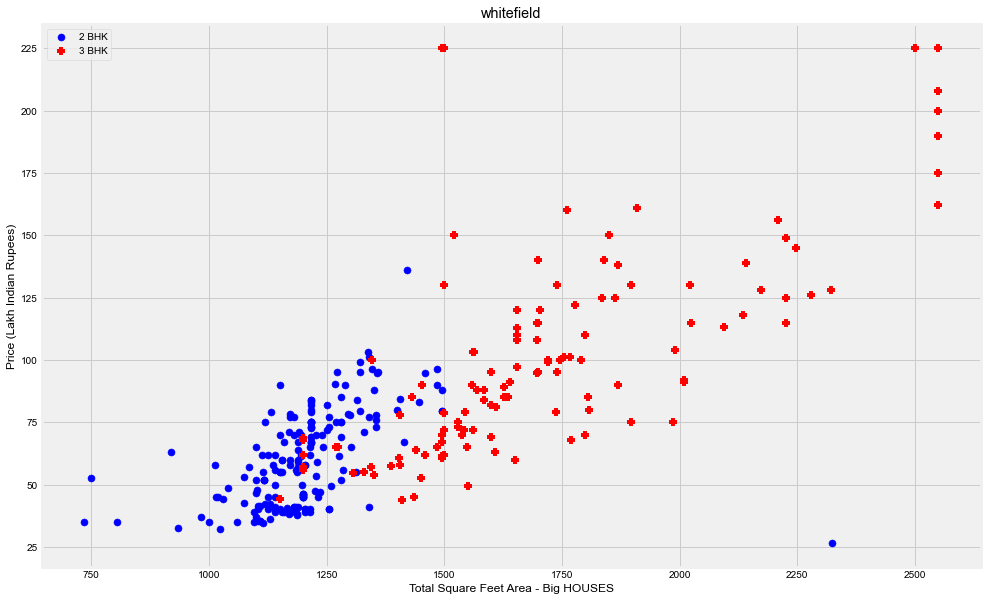

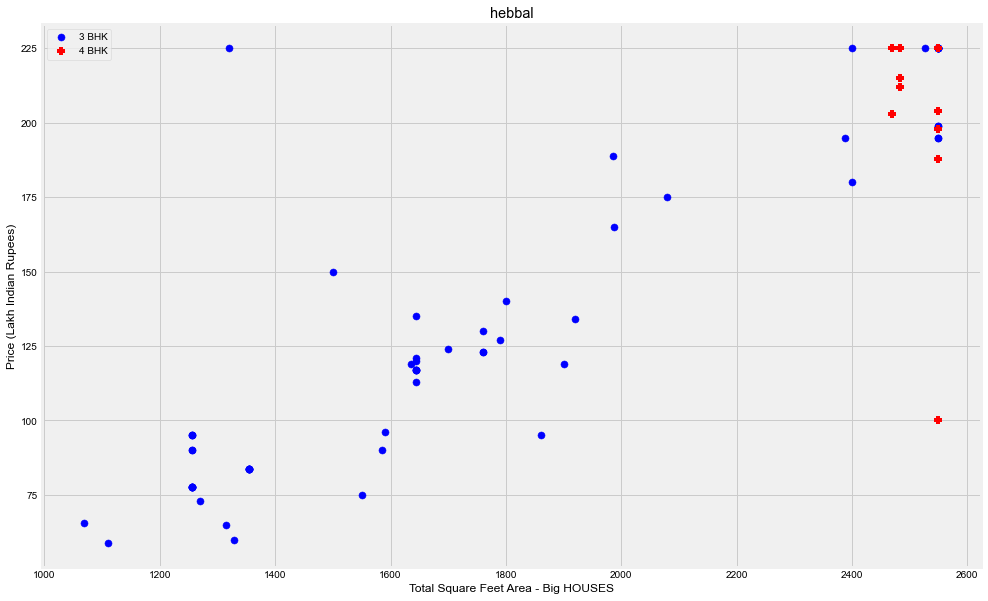

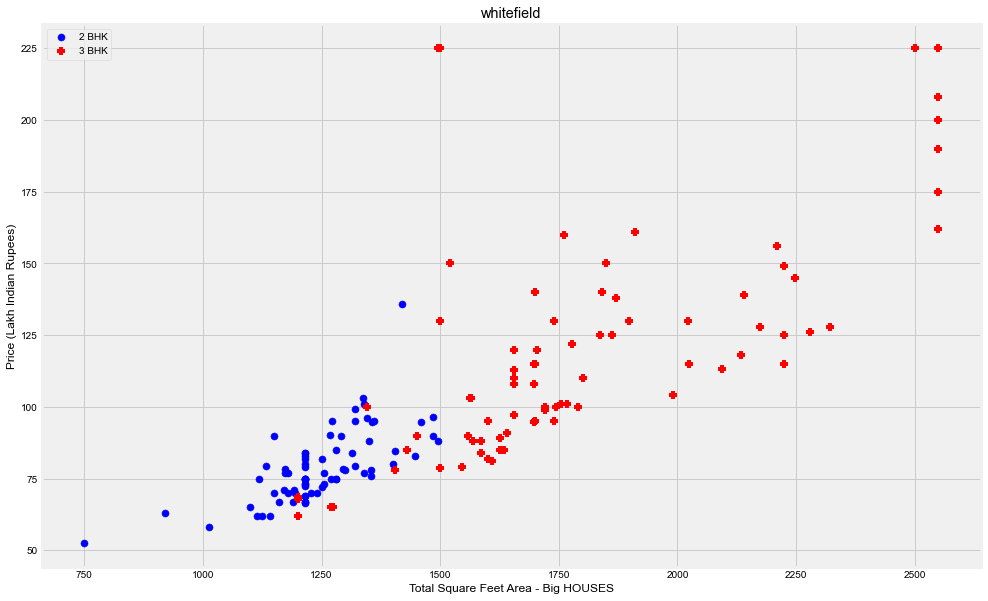

('loc_lat', 'loc_long')
('loc_lat', 'total_sqft')
('loc_lat', 'bath')
('loc_lat', 'balcony')
('loc_lat', 'room_count')
('loc_lat', 'price_per_square_ft')
('loc_lat', 'sqft_per_bhk')
('loc_lat', 'dist')
('loc_long', 'total_sqft')
('loc_long', 'bath')
('loc_long', 'balcony')
('loc_long', 'room_count')
('loc_long', 'price_per_square_ft')
('loc_long', 'sqft_per_bhk')
('loc_long', 'dist')
('total_sqft', 'bath')
('total_sqft', 'balcony')
('total_sqft', 'room_count')
('total_sqft', 'price_per_square_ft')
('total_sqft', 'sqft_per_bhk')
('total_sqft', 'dist')
('bath', 'balcony')
('bath', 'room_count')
('bath', 'price_per_square_ft')
('bath', 'sqft_per_bhk')
('bath', 'dist')
('balcony', 'room_count')
('balcony', 'price_per_square_ft')
('balcony', 'sqft_per_bhk')
('balcony', 'dist')
('room_count', 'price_per_square_ft')
('room_count', 'sqft_per_bhk')
('room_count', 'dist')
('price_per_square_ft', 'sqft_per_bhk')
('price_per_square_ft', 'dist')
('sqft_per_bhk', 'dist')
0.9348150934183797 ('bath', 

In [55]:
# Gettign the data after pre-processing
X,y = preprocess_data(df)

In [50]:
df_5.head()

,bath,balcony,total_sqft,interaction,room_count,dist,loc_lat,loc_long,area_type,availability,...,kitchen,room_size,price_per_square_ft,north,north east,north west,south,south east,south west,west
0,2.0,-1.0,1.792071,2.00,2.0,0.0,-0.283173,-0.074774,4,1,...,0.0,1.0,119275.453065,0,0,0,0,1,0,0
1,1.0,0.0,0.465210,0.60,1.0,0.0,0.155321,-1.424492,3,1,...,1.0,1.0,55194.805195,0,0,0,0,0,0,1
2,2.5,-1.0,0.885922,2.40,2.0,0.0,0.155321,-1.424492,2,1,...,0.0,1.0,119275.453065,0,0,0,0,0,0,1
3,2.5,1.0,2.018608,2.85,2.5,0.0,0.594821,-0.040726,4,1,...,0.0,1.0,119275.453065,0,1,0,0,0,0,0
4,-1.0,-2.0,-1.055825,-1.00,-1.0,0.0,0.594821,-0.040726,3,1,...,1.0,1.0,75000.000000,0,1,0,0,0,0,0


In [56]:
y.head()

0    225.0
1     85.0
2    225.0
3    225.0
4     45.0
Name: price, dtype: float64

## Creating Models

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [58]:
find_best_model_using_gridsearchcv(X, y)

,model,best_score,best_params
0,linear_regression,0.933702,{'normalize': True}
1,lasso,0.933301,"{'alpha': 0.1, 'selection': 'random'}"
2,ridge,0.933705,{'alpha': 0.9}
3,random_forest,0.972738,"{'max_depth': 20, 'n_estimators': 500}"
4,xgboost,0.969716,{'n_estimators': 100}


In [59]:
lasso_reg = Lasso(alpha = 0.1)
lasso_reg.fit(X, y)
lasso_reg.score(X, y)

0.9342860110905632

In [60]:
column_labels = df_5.columns.tolist()
coef = lasso_reg.coef_.squeeze().tolist()

# Zip together
labels_coef = list(zip(column_labels, coef))

# Verify the result
print(labels_coef)

[('bath', -5.695533159826776), ('balcony', 0.0), ('total_sqft', 41.10044424864288), ('interaction', 12.906235917958087), ('room_count', -6.526334228970165), ('dist', 0.0), ('loc_lat', -0.0037857741407208924), ('loc_long', 0.006401847408792257), ('area_type', -0.0), ('availability', 0.0), ('hall', -0.9391520511179671), ('kitchen', -0.0), ('room_size', 0.0), ('price_per_square_ft', 0.0013168834345642156), ('north', -0.0), ('north east', -0.2980198446710143), ('north west', 0.0), ('south', -0.0), ('south east', 0.0), ('south west', 0.0), ('west', 0.0)]


In [861]:
valid_list_of_columns = []
for label_coeff in labels_coef:
    label = label_coeff[0]
    coeff = label_coeff[1]
    if np.abs(coeff) == 0:
        pass
    else:
        valid_list_of_columns.append(label)
valid_list_of_columns

['bath',
 'balcony',
 'total_sqft',
 'interaction',
 'room_count',
 'dist',
 'loc_lat',
 'loc_long',
 'area_type',
 'availability',
 'hall',
 'room_size',
 'north',
 'north east',
 'north west',
 'south east',
 'west']

In [862]:
X, y = df_5[valid_list_of_columns].values, price.values
X_train, X_test, y_train, y_test = train_test_split(df_5[valid_list_of_columns], price, test_size = 0.2, random_state = 42) 

In [61]:
lasso_reg = Lasso(alpha = 0.1)
lasso_reg.fit(X, y)
lasso_reg.score(X, y)

0.9342860110905632

<AxesSubplot:xlabel='price'>

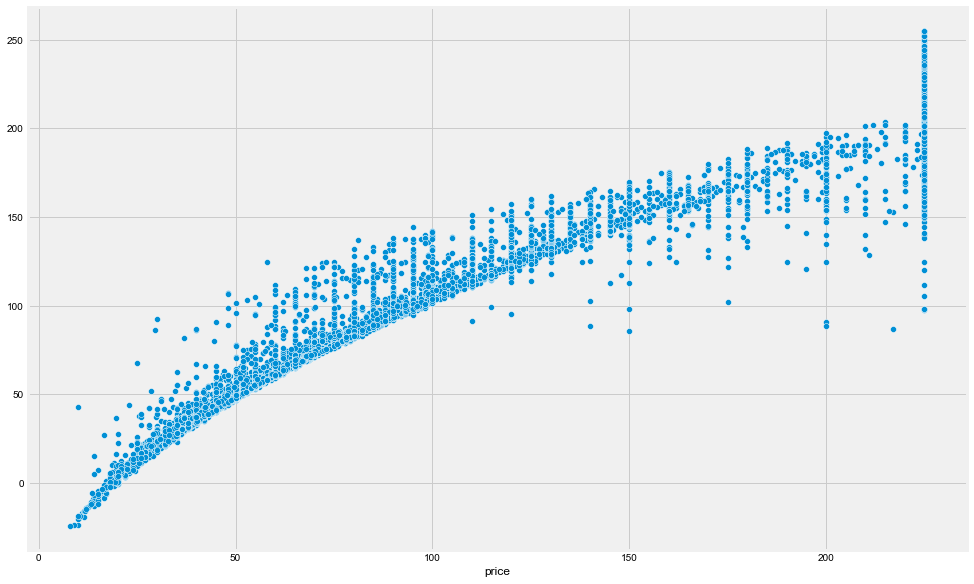

In [62]:
y_pred = lasso_reg.predict(X)
sns.scatterplot(x=y, y=y_pred)

In [63]:
lin_reg = LinearRegression(normalize=False)
lin_reg.fit(X, y)
lin_reg.score(X, y)

0.9348857562908955

<AxesSubplot:xlabel='price'>

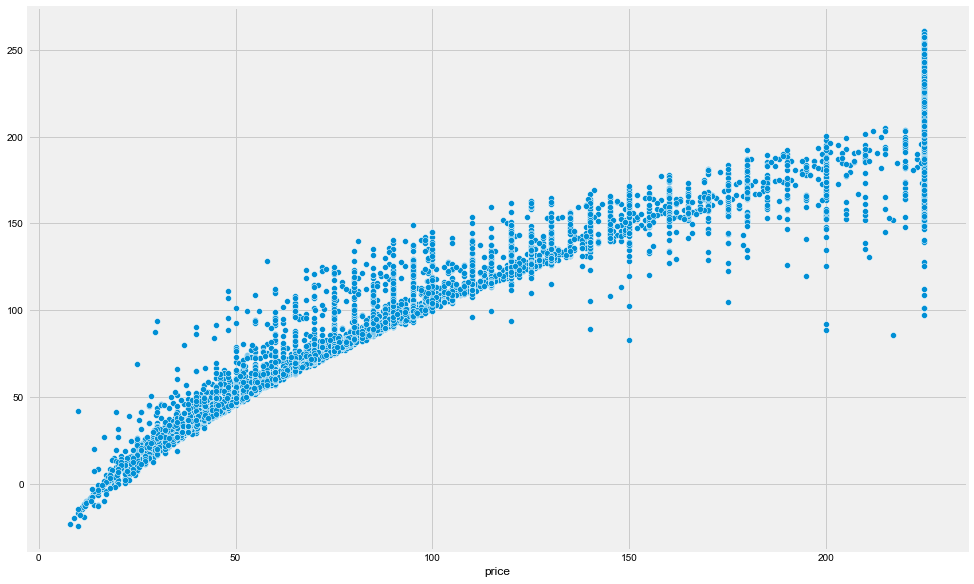

In [64]:
y_pred = lin_reg.predict(X)
sns.scatterplot(x=y, y=y_pred)

In [65]:
ridge_reg = Ridge(alpha = 0.9)
ridge_reg.fit(X, y)
ridge_reg.score(X, y)

0.9348856213355738

<AxesSubplot:xlabel='price'>

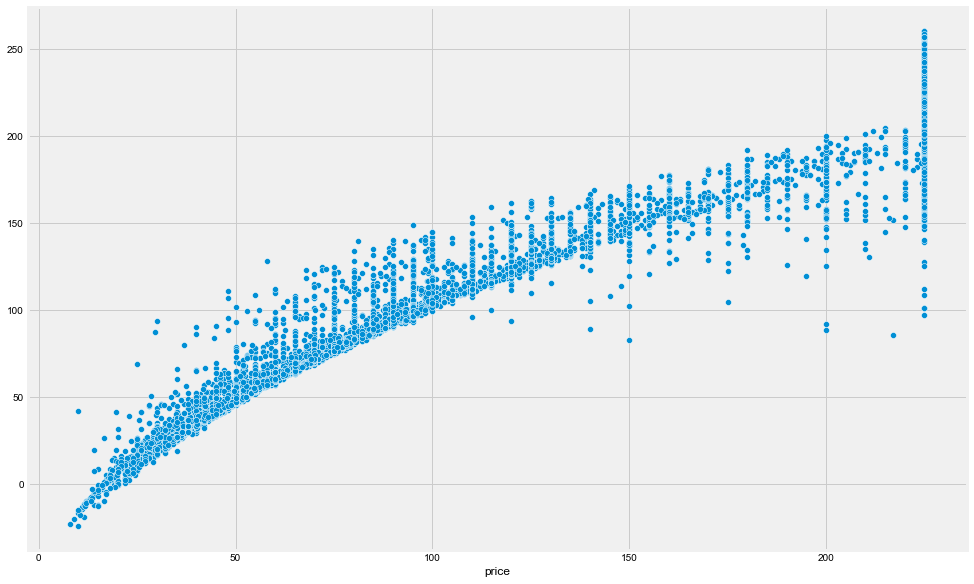

In [66]:
y_pred = ridge_reg.predict(X)
sns.scatterplot(x=y, y=y_pred)

In [68]:
dt_reg = DecisionTreeRegressor()
dt_reg.fit(X, y)
dt_reg.score(X, y)

0.999970344101107

<AxesSubplot:xlabel='price'>

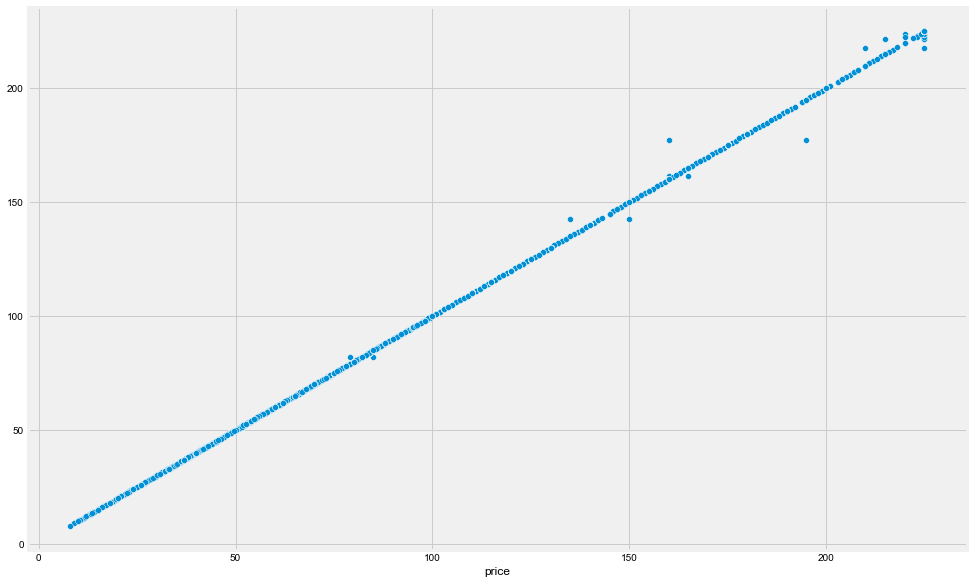

In [69]:
y_pred = dt_reg.predict(X)
sns.scatterplot(x=y, y=y_pred)

In [71]:
rf_reg = RandomForestRegressor(n_estimators=500, max_depth=20)
rf_reg.fit(X, y)
rf_reg.score(X, y)

0.9967062993962091

<AxesSubplot:xlabel='price'>

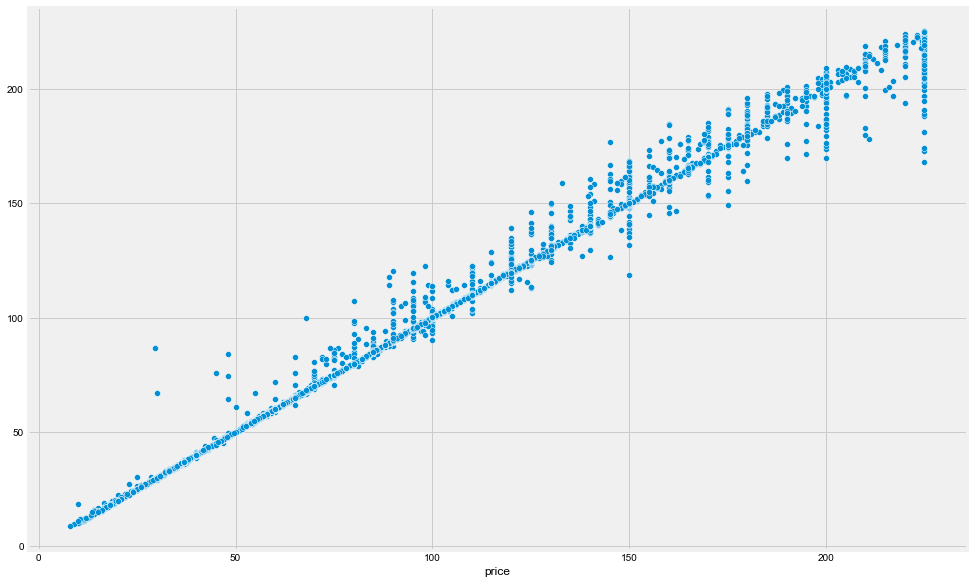

In [72]:
y_pred = rf_reg.predict(X)
sns.scatterplot(x=y, y=y_pred)

In [73]:
ab_reg = AdaBoostRegressor(loss = "linear")
ab_reg.fit(X, y)
ab_reg.score(X, y)

0.8775283119571995

<AxesSubplot:xlabel='price'>

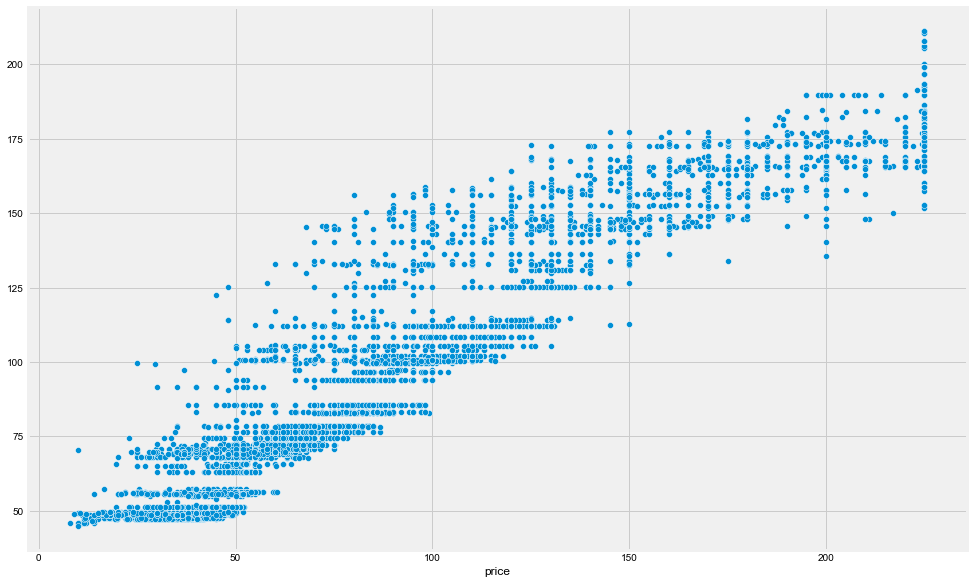

In [74]:
y_pred = ab_reg.predict(X)
sns.scatterplot(x=y, y=y_pred)

In [75]:
gb_reg = GradientBoostingRegressor(n_estimators=100)
gb_reg.fit(X, y)
gb_reg.score(X, y)

0.98017407652451

<AxesSubplot:xlabel='price'>

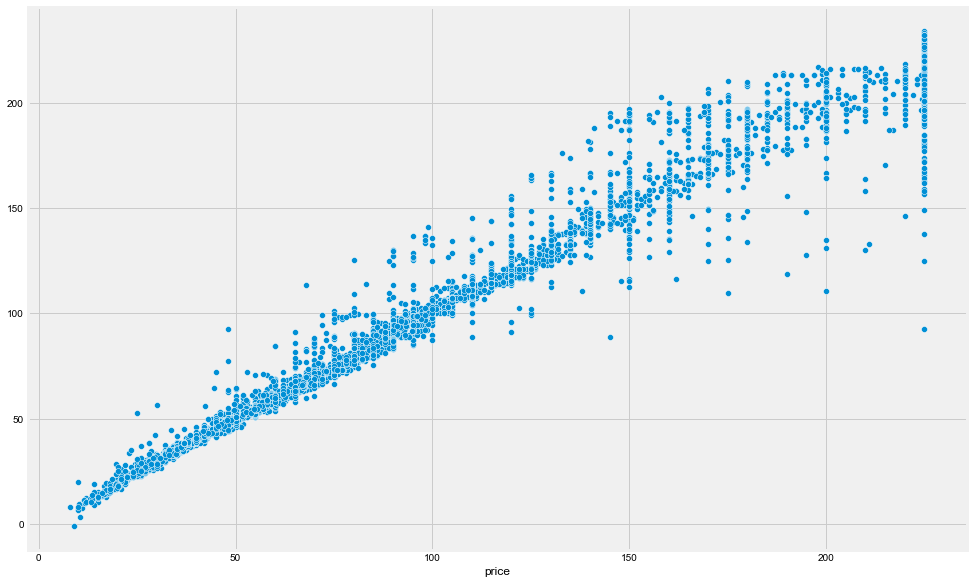

In [76]:
y_pred = gb_reg.predict(X)
sns.scatterplot(x=y, y=y_pred)

In [77]:
# Taking XGBRegressor as it is giving the best performance
xgb_reg = XGBRegressor(n_estimators=100)
xgb_reg.fit(X, y)
xgb_reg.score(X, y)

0.9975610022271646

<AxesSubplot:xlabel='price'>

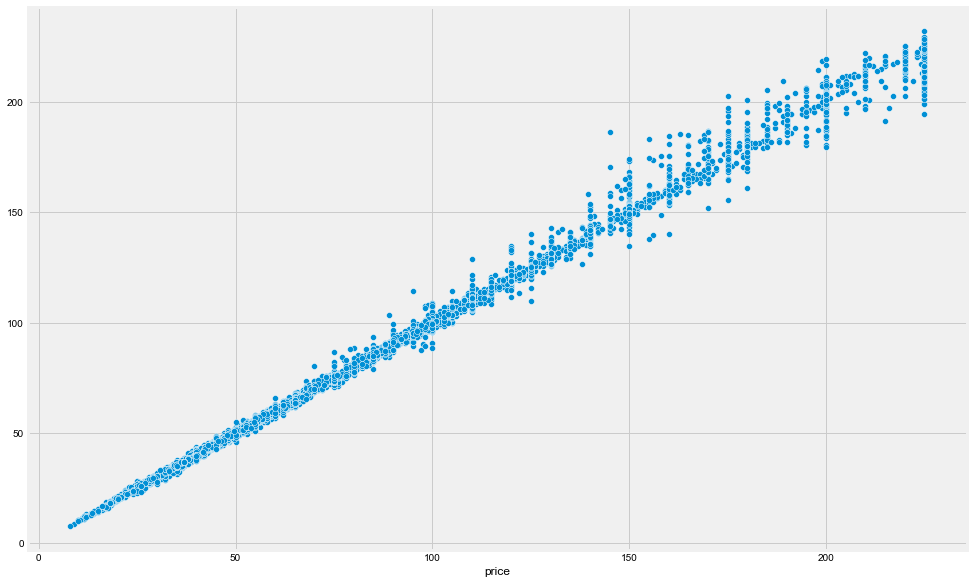

In [78]:
y_pred = xgb_reg.predict(X)
sns.scatterplot(x=y, y=y_pred)

In [79]:
# Trying Grid Search CV with ElasticNet
hyp_param = {'alpha':[0.002, 0.01, 0.02], 'l1_ratio':[0.999, 1, 2]}
enet = ElasticNet(normalize=True)
hyper_model = GridSearchCV(estimator=enet, param_grid=hyp_param, cv=5, scoring='r2')

enet_model = hyper_model.fit(X, y)
enet_rmse = rmse(enet_model.predict(X),y)
print(f"Best Hyper Parameter: {enet_model.best_params_}")
print(f"Best Score: {enet_model.best_score_} | RMSE: {enet_rmse}")

Best Hyper Parameter: {'alpha': 0.002, 'l1_ratio': 1}
Best Score: 0.9327134084805351 | RMSE: 15.908805758428239


<AxesSubplot:xlabel='price'>

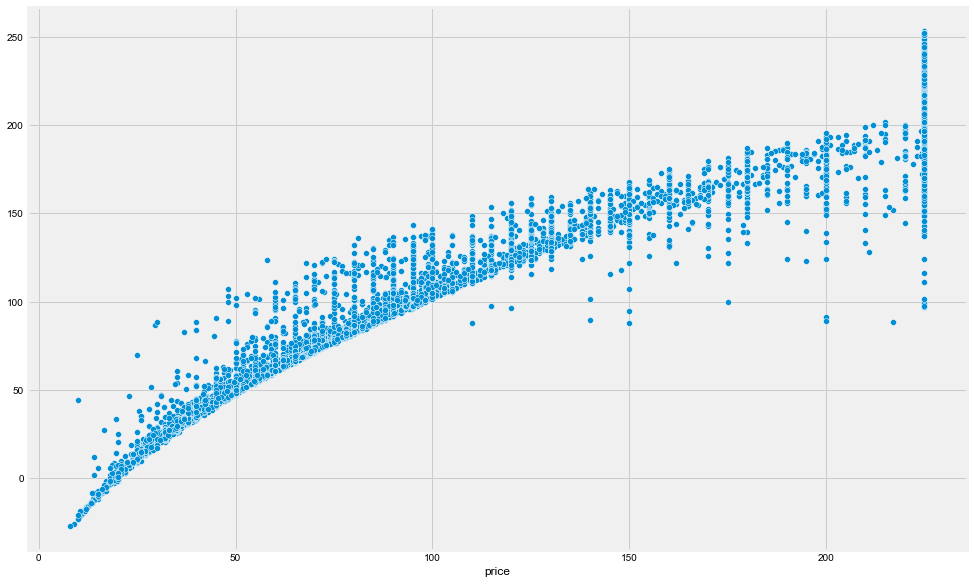

In [80]:
y_pred = enet_model.predict(X)
sns.scatterplot(x=y, y=y_pred)

In [81]:
from sklearn.ensemble import HistGradientBoostingRegressor

est = HistGradientBoostingRegressor().fit(X, y)
y_pred = est.predict(X)
rmse_hgbr = rmse(y_pred, y)
print(est.score(X, y), rmse_hgbr)

0.989967945905963 6.170997792485253


<AxesSubplot:xlabel='price'>

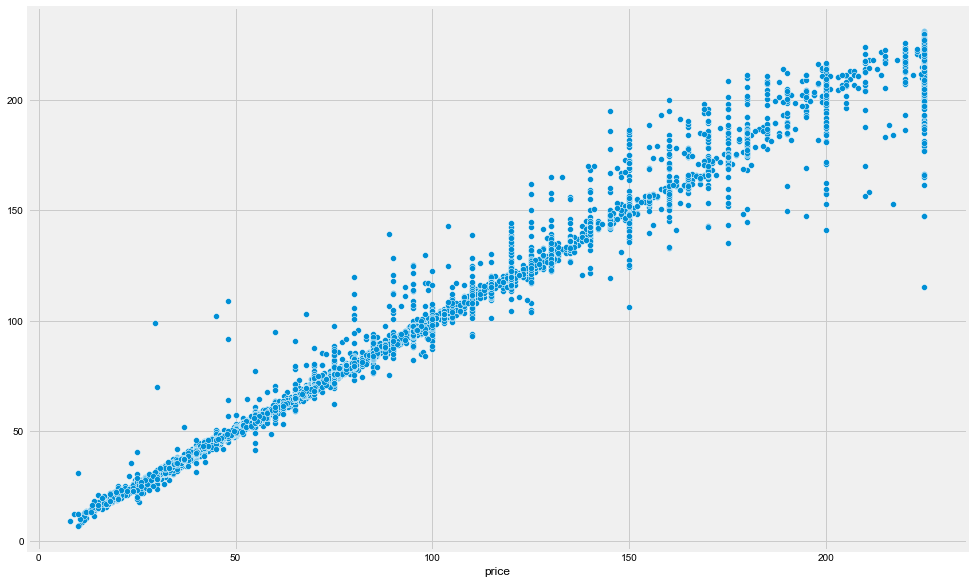

In [82]:
y_pred = est.predict(X)
sns.scatterplot(x=y, y=y_pred)

## PROCESSING THE TEST-DATA

In [162]:
df_test.head()

,Unnamed: 0,ID,area_type,availability,location,size,society,total_sqft,bath,balcony,loc_lat,loc_long,dir_from_centre
0,0,0,Super built-up Area,0,Chamrajpet,2 BHK,NaN,650,1.0,1.0,12.956997,77.563368,south west
1,1,1,Super built-up Area,0,7th Phase JP Nagar,3 BHK,SrncyRe,1370,2.0,1.0,12.912432,77.575952,south
2,2,2,Super built-up Area,0,Whitefield,3 BHK,AjhalNa,1725,3.0,2.0,12.969637,77.749745,east
3,3,3,Built-up Area,0,Jalahalli,2 BHK,NaN,1000,2.0,0.0,13.046453,77.548380,north west
4,4,4,Plot Area,0,TC Palaya,1 Bedroom,NaN,1350,1.0,0.0,13.009855,77.693089,east


In [163]:
df_test['location'] = df_test['location'].apply(lambda x: str(x).lower().strip().replace('  ', ' '))

In [164]:
df_test['availability'] = df_test['availability'].apply(lambda x: 1 if x=="Ready To Move" else 0)

In [165]:
df_test_1 = df_test.drop(columns=["ID", "society", "Unnamed: 0"])
df_test_1.isna().sum()

area_type            0
availability         0
location             0
size                 2
total_sqft           0
bath                 8
balcony            105
loc_lat              4
loc_long             4
dir_from_centre      4
dtype: int64

In [166]:
df_test_1['location'] = df_test_1['location'].fillna('Whitefield')

In [167]:
df_test_1['size'] = df_test_1['size'].fillna('2 BHK')

# Creating 3 additional columns
df_test_1['hall'] = np.nan
df_test_1['kitchen'] = np.nan
df_test_1['room_count'] = np.nan

for index, row in df_test_1.iterrows():
    split_size(df_test_1, index, df_test_1.loc[index, 'size'])
    
df_test_1[['room_count']] = df_test_1[['room_count']].astype(float)    

In [168]:
df_test_1.head()

,area_type,availability,location,size,total_sqft,bath,balcony,loc_lat,loc_long,dir_from_centre,hall,kitchen,room_count
0,Super built-up Area,0,chamrajpet,2 BHK,650,1.0,1.0,12.956997,77.563368,south west,1.0,1.0,2.0
1,Super built-up Area,0,7th phase jp nagar,3 BHK,1370,2.0,1.0,12.912432,77.575952,south,1.0,1.0,3.0
2,Super built-up Area,0,whitefield,3 BHK,1725,3.0,2.0,12.969637,77.749745,east,1.0,1.0,3.0
3,Built-up Area,0,jalahalli,2 BHK,1000,2.0,0.0,13.046453,77.548380,north west,1.0,1.0,2.0
4,Plot Area,0,tc palaya,1 Bedroom,1350,1.0,0.0,13.009855,77.693089,east,0.0,0.0,1.0


In [169]:
df_test_1.isna().sum()

area_type            0
availability         0
location             0
size                 0
total_sqft           0
bath                 8
balcony            105
loc_lat              4
loc_long             4
dir_from_centre      4
hall                 0
kitchen              0
room_count           0
dtype: int64

In [170]:
# Getting rid of all NaN from latitude column
df_test_1[df_test_1['loc_lat'].isna()]

,area_type,availability,location,size,total_sqft,bath,balcony,loc_lat,loc_long,dir_from_centre,hall,kitchen,room_count
998,Super built-up Area,0,javarandoddi,1 BHK,648,1.0,1.0,NaN,NaN,NaN,1.0,1.0,1.0
1123,Built-up Area,0,devasthanagalu,3 BHK,1470,2.0,3.0,NaN,NaN,NaN,1.0,1.0,3.0
1438,Built-up Area,0,volagerekallahalli,2 BHK,1095,2.0,1.0,NaN,NaN,NaN,1.0,1.0,2.0
1974,Super built-up Area,0,devasthanagalu,2 BHK,1057,2.0,1.0,NaN,NaN,NaN,1.0,1.0,2.0


In [171]:
# Getting rid of all NaN from longitude column
df_test_1[df_test_1['loc_long'].isna()]

,area_type,availability,location,size,total_sqft,bath,balcony,loc_lat,loc_long,dir_from_centre,hall,kitchen,room_count
998,Super built-up Area,0,javarandoddi,1 BHK,648,1.0,1.0,NaN,NaN,NaN,1.0,1.0,1.0
1123,Built-up Area,0,devasthanagalu,3 BHK,1470,2.0,3.0,NaN,NaN,NaN,1.0,1.0,3.0
1438,Built-up Area,0,volagerekallahalli,2 BHK,1095,2.0,1.0,NaN,NaN,NaN,1.0,1.0,2.0
1974,Super built-up Area,0,devasthanagalu,2 BHK,1057,2.0,1.0,NaN,NaN,NaN,1.0,1.0,2.0


In [172]:
# Mapping the relatively known areas for those areas whose geocodes is not known
# devasthanagalu : varthur
# javarandoddi : rr nagar
# volagerekallahalli : Chikkadasarahalli
# dominic layout : Kodigehalli
# cooketown : banaswadi
# devasandra extension : kr puram
# bsm extension : kengeri
# chuchangatta colony : patel narayanappa layout
# havanur extension : nagasandra
df_test_1.loc[(df_test_1['location']=="javarandoddi"), 'loc_lat'] = get_geocode("rr nagar").split("-")[0]
df_test_1.loc[(df_test_1['location']=="javarandoddi"), 'loc_long'] = get_geocode("rr nagar").split("-")[1]
df_test_1.loc[(df_test_1['location']=="javarandoddi"), 'dir_from_centre']=get_direction_from_city_centre(get_geocode("rr nagar"))
df_test_1.loc[(df_test_1['location']=="devasthanagalu"),'loc_lat'] = get_geocode("varthur").split("-")[0]
df_test_1.loc[(df_test_1['location']=="devasthanagalu"),'loc_long'] = get_geocode("varthur").split("-")[1]
df_test_1.loc[(df_test_1['location']=="devasthanagalu"), 'dir_from_centre']=get_direction_from_city_centre(get_geocode("varthur"))
df_test_1.loc[(df_test_1['location']=="volagerekallahalli"),'loc_lat'] = get_geocode("chikkadasarahalli").split("-")[0]
df_test_1.loc[(df_test_1['location']=="volagerekallahalli"),'loc_long'] = get_geocode("chikkadasarahalli").split("-")[1]
df_test_1.loc[(df_test_1['location']=="volagerekallahalli"), 'dir_from_centre']=get_direction_from_city_centre(get_geocode("chikkadasarahalli"))
# df_test_1.loc[(df_test_1['location']=="dominic layout"),'loc_lat'] = get_geocode("kodigehalli").split("-")[0]
# df_test_1.loc[(df_test_1['location']=="cooketown"),'loc_long'] = get_geocode("banaswadi").split("-")[1]
# df_test_1.loc[(df_test_1['location']=="devasandra extension"),'loc_long'] = get_geocode("kr puram").split("-")[1]
# df_test_1.loc[(df_test_1['location']=="bsm extension"),'loc_long'] = get_geocode("kengeri").split("-")[1]
# df_test_1.loc[(df_test_1['location']=="chuchangatta colony"),'loc_long'] = get_geocode("patel narayanappa layout").split("-")[1]
# df_test_1.loc[(df_test_1['location']=="havanur extension"),'loc_long'] = get_geocode("nagasandra").split("-")[1]

rr nagar
rr nagar
rr nagar
12.9331339-77.5298694
varthur
varthur
varthur
12.9406152-77.7469937
chikkadasarahalli
chikkadasarahalli
chikkadasarahalli
13.602110000000039-76.93465000000003


In [173]:
df_test_1.loc[df_test_1["loc_lat"].isna()]

,area_type,availability,location,size,total_sqft,bath,balcony,loc_lat,loc_long,dir_from_centre,hall,kitchen,room_count


In [174]:
df_test_1.loc[df_test_1["loc_long"]==""]

,area_type,availability,location,size,total_sqft,bath,balcony,loc_lat,loc_long,dir_from_centre,hall,kitchen,room_count


<AxesSubplot:xlabel='room_count', ylabel='bath'>

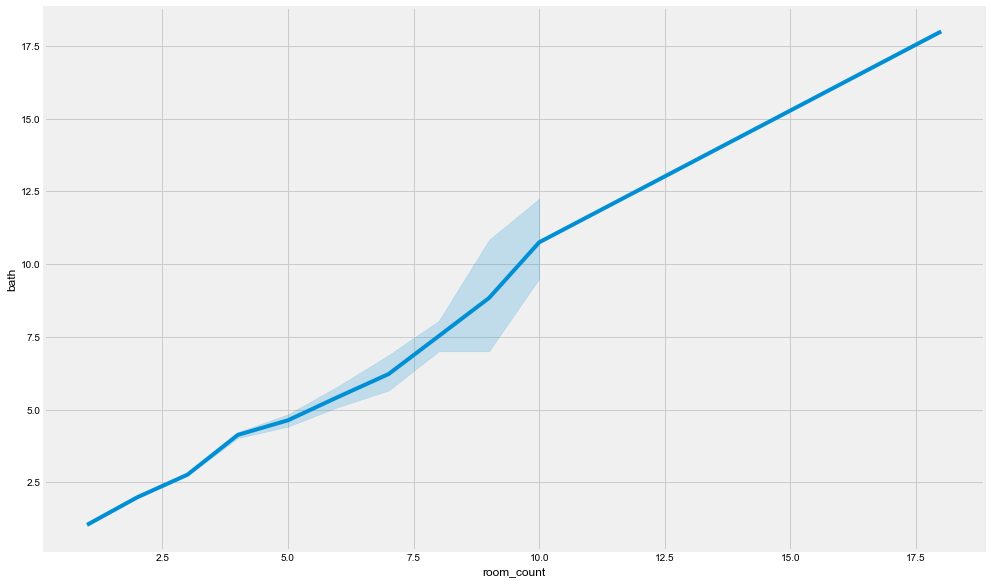

In [175]:
# Trying to find if room_count and number of bathrooms are linearly correlated
sns.lineplot(x=df_test_1['room_count'], y=df_test_1['bath'])

In [176]:
median_bath_df = pd.DataFrame(df.groupby('size')['bath'].median())

In [177]:
# Filling the NaN values in bath with corresponding median for the respective room size from median_bath_df
for index, row in df_test_1.iterrows():
    if np.isnan(df_test_1.loc[index, 'bath']):
        df_test_1.loc[index, 'bath'] = median_bath_df.loc[df_test_1.loc[index,'size']].values[0]


In [178]:
# Replacing all the NaN values in balcony witht the median of the subgroup based on number of rooms
balcony_df = pd.DataFrame(df.groupby('size')['balcony'].median())

In [179]:
# Filling NaN values with corresponding mean for the respective room size
for index, row in df_test_1.iterrows():
    if np.isnan(df_test_1.loc[index, 'balcony']):
        if df_test_1.loc[index,'size'] in balcony_df.index:
            df_test_1.loc[index, 'balcony'] = balcony_df.loc[df_test_1.loc[index,'size']].values[0]
        else:
            df_test_1.loc[index, 'balcony'] = 0

In [180]:
df_test_1.head()

,area_type,availability,location,size,total_sqft,bath,balcony,loc_lat,loc_long,dir_from_centre,hall,kitchen,room_count
0,Super built-up Area,0,chamrajpet,2 BHK,650,1.0,1.0,12.956997,77.563368,south west,1.0,1.0,2.0
1,Super built-up Area,0,7th phase jp nagar,3 BHK,1370,2.0,1.0,12.912432,77.575952,south,1.0,1.0,3.0
2,Super built-up Area,0,whitefield,3 BHK,1725,3.0,2.0,12.969637,77.749745,east,1.0,1.0,3.0
3,Built-up Area,0,jalahalli,2 BHK,1000,2.0,0.0,13.046453,77.54838,north west,1.0,1.0,2.0
4,Plot Area,0,tc palaya,1 Bedroom,1350,1.0,0.0,13.009855,77.693089,east,0.0,0.0,1.0


In [181]:
df_test_1["total_sqft"] = df_test_1["total_sqft"].apply(units_in_sq_ft)

In [182]:
df_test_1.isna().sum()

area_type          0
availability       0
location           0
size               0
total_sqft         0
bath               0
balcony            0
loc_lat            0
loc_long           0
dir_from_centre    0
hall               0
kitchen            0
room_count         0
dtype: int64

In [183]:
df_test_1[['total_sqft','room_count']] = df_test_1[['total_sqft','room_count']].astype(float)

In [184]:
df_test_1["sqft_per_bhk"] = df_test_1['total_sqft']/df_test_1['room_count']

In [185]:
df_test_1['room_size'] = np.nan
for index, row in df_test_1.iterrows():
    if df_test_1.loc[index,'total_sqft']/df_test_1.loc[index,'room_count'] < 300:
        df_test_1.loc[index, 'room_size'] = 0
    else:
        df_test_1.loc[index, 'room_size'] = 1

In [186]:
df_test_1['room_size'] = np.nan
for index, row in df_test_1.iterrows():
    if df_test_1.loc[index,'total_sqft']/df_test_1.loc[index,'room_count'] < 300:
        df_test_1.loc[index, 'room_size'] = 0
    else:
        df_test_1.loc[index, 'room_size'] = 1


In [187]:
df_test_1['dist'] = df_test_1['location'].apply(get_dist)
df_test_1.head()

,area_type,availability,location,size,total_sqft,bath,balcony,loc_lat,loc_long,dir_from_centre,hall,kitchen,room_count,sqft_per_bhk,room_size,dist
0,Super built-up Area,0,chamrajpet,2 BHK,650.0,1.0,1.0,12.956997,77.563368,south west,1.0,1.0,2.0,325.000000,1.0,13.05
1,Super built-up Area,0,7th phase jp nagar,3 BHK,1370.0,2.0,1.0,12.912432,77.575952,south,1.0,1.0,3.0,456.666667,1.0,13.05
2,Super built-up Area,0,whitefield,3 BHK,1725.0,3.0,2.0,12.969637,77.749745,east,1.0,1.0,3.0,575.000000,1.0,13.05
3,Built-up Area,0,jalahalli,2 BHK,1000.0,2.0,0.0,13.046453,77.54838,north west,1.0,1.0,2.0,500.000000,1.0,13.05
4,Plot Area,0,tc palaya,1 Bedroom,1350.0,1.0,0.0,13.009855,77.693089,east,0.0,0.0,1.0,1350.000000,1.0,13.05


In [188]:
# Dropping columns for later
df_test_1.drop(columns=["size"], inplace=True)
# df_test_1["location"] = df_test_1["location"].apply(lambda x : "other" if (x in unique_location_count_10) or (x not in set_location_in_both_train_test_data) else x)

In [907]:
# df_test_1['latitude'].apply(lambda x : print(re.findall(r'\d+\.\d+', x)))

In [189]:
df_test_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2664 entries, 0 to 2663
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   area_type        2664 non-null   object 
 1   availability     2664 non-null   int64  
 2   location         2664 non-null   object 
 3   total_sqft       2664 non-null   float64
 4   bath             2664 non-null   float64
 5   balcony          2664 non-null   float64
 6   loc_lat          2664 non-null   object 
 7   loc_long         2664 non-null   object 
 8   dir_from_centre  2664 non-null   object 
 9   hall             2664 non-null   float64
 10  kitchen          2664 non-null   float64
 11  room_count       2664 non-null   float64
 12  sqft_per_bhk     2664 non-null   float64
 13  room_size        2664 non-null   float64
 14  dist             2664 non-null   float64
dtypes: float64(9), int64(1), object(5)
memory usage: 312.3+ KB


In [190]:
# Ordinal Encoding to area_type
ordinal_encoding_area_dict = {"Carpet  Area":1, "Built-up  Area":2, "Plot  Area":4, "Super built-up  Area":3}
df_test_1['area_type'] = df_test_1['area_type'].map(ordinal_encoding_area_dict)

In [191]:
df_test_1[["loc_lat", "loc_long"]] = df_test_1[["loc_lat","loc_long"]].astype(float)

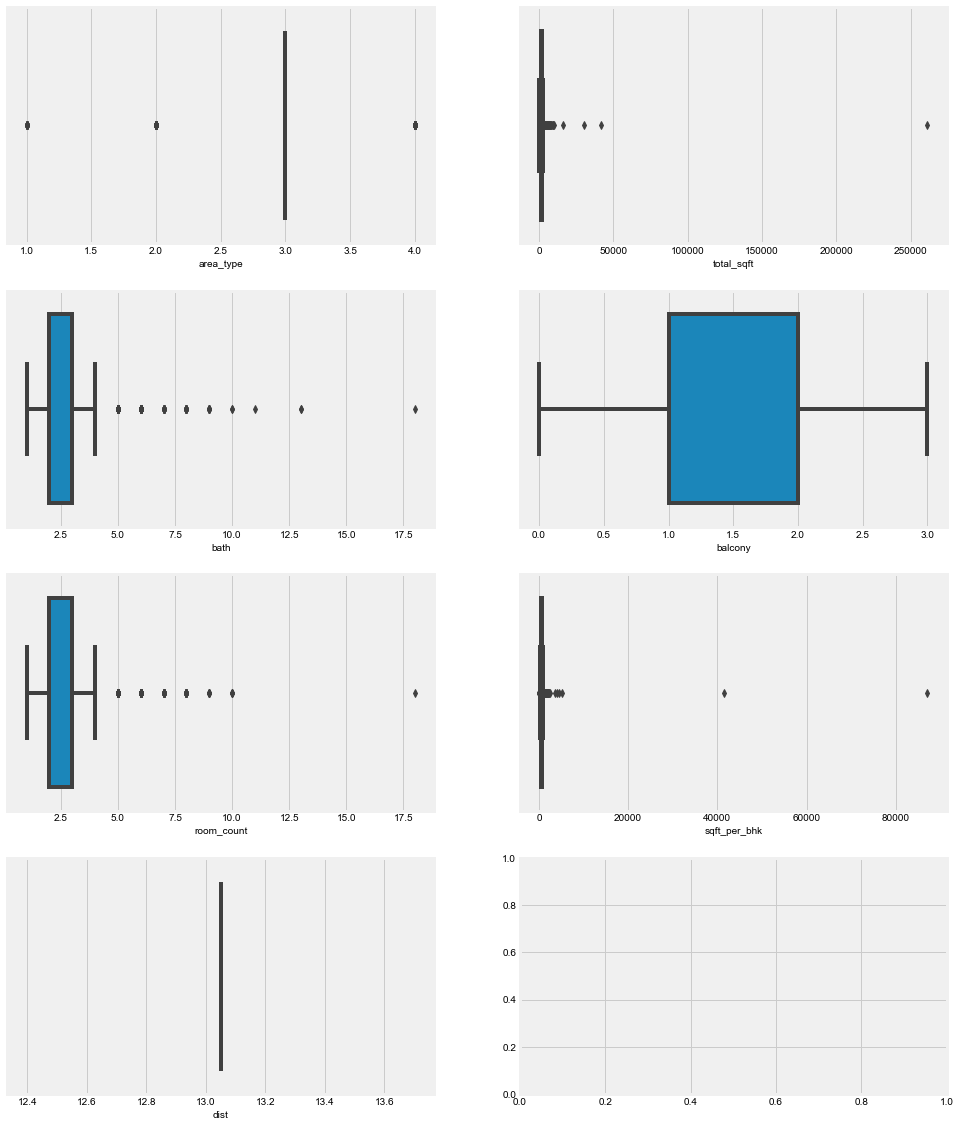

In [192]:
df_num = df_test_1.select_dtypes(include=np.number)
# Dropping the categorical columns which are only numerically encoded
df_num.drop(columns=["availability","hall","kitchen","room_size","loc_lat","loc_long"], inplace=True)
fig,ax = plt.subplots(4,2, figsize=(15,20))

for col, sub in zip(df_num, ax.flatten()):
    z=sns.boxplot(x=df_num[col], ax=sub, orient='h')
    z.set_xlabel(col, fontsize=10)

In [912]:
# Getting rid of the outliers from originally numeric column
# for col in df_num.columns:
#     tempdata = df_num[col]
#     q1,q3 = tempdata.quantile([0.25,0.75])
#     IQR = q3-q1
#     print(col, q1,q3, IQR)
#     lr = q1-1.5*IQR
#     ur = q3+1.5*IQR
#     # Replacing the values 
#     df_num[col] = df_num[col].apply(lambda x: x if x <= ur else ur)
#     df_num[col] = df_num[col].apply(lambda x: x if x >= lr else lr)


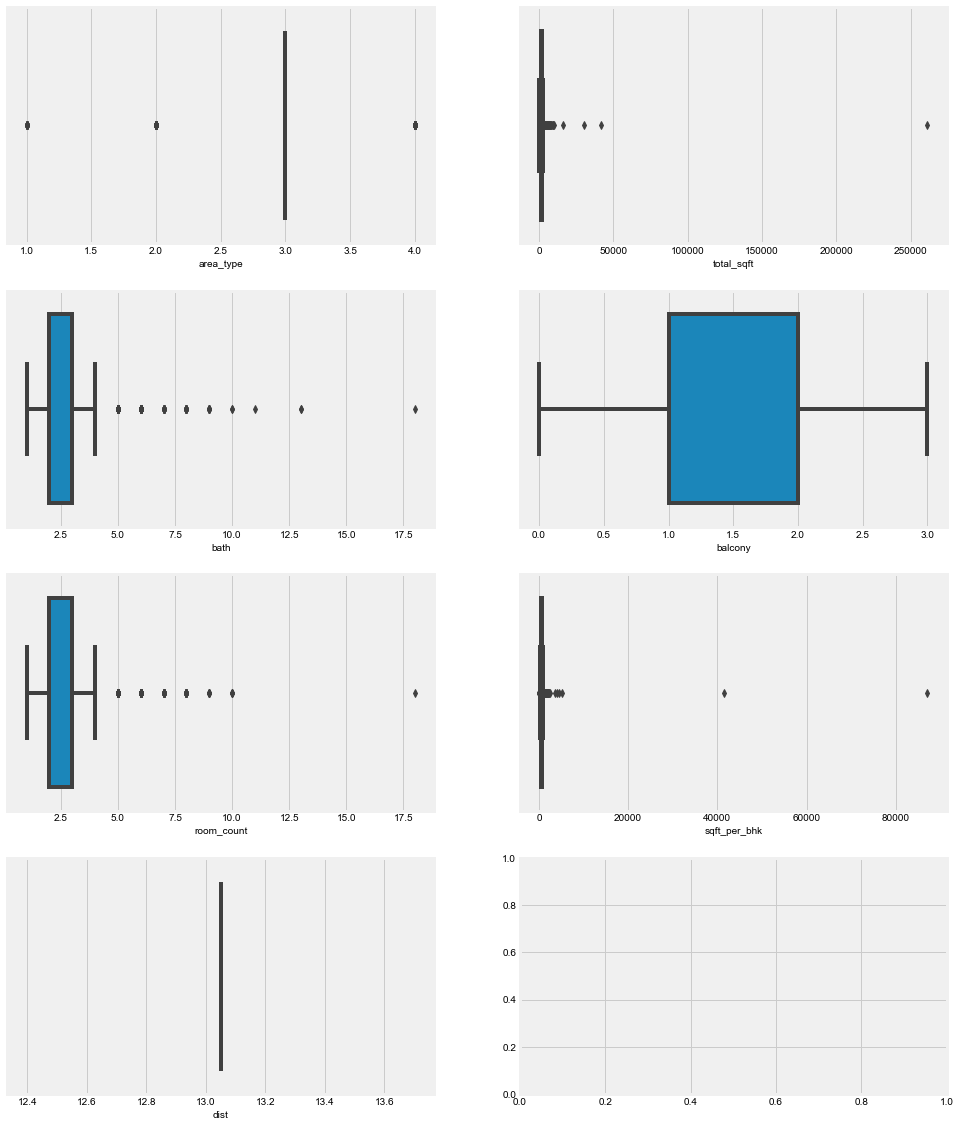

In [193]:
fig,ax = plt.subplots(4,2, figsize=(15,20))

for col, sub in zip(df_num, ax.flatten()):
    z=sns.boxplot(x=df_num[col], ax=sub, orient='h')
    z.set_xlabel(col, fontsize=10)

In [194]:
df_test_2 = pd.concat([df_test_1.drop(columns=df_num.columns), df_num], axis=1)
print(df_test_2.shape)
df_test_2.head()

(2664, 15)


,availability,location,loc_lat,loc_long,dir_from_centre,hall,kitchen,room_size,area_type,total_sqft,bath,balcony,room_count,sqft_per_bhk,dist
0,0,chamrajpet,12.956997,77.563368,south west,1.0,1.0,1.0,3,650.0,1.0,1.0,2.0,325.000000,13.05
1,0,7th phase jp nagar,12.912432,77.575952,south,1.0,1.0,1.0,3,1370.0,2.0,1.0,3.0,456.666667,13.05
2,0,whitefield,12.969637,77.749745,east,1.0,1.0,1.0,3,1725.0,3.0,2.0,3.0,575.000000,13.05
3,0,jalahalli,13.046453,77.548380,north west,1.0,1.0,1.0,2,1000.0,2.0,0.0,2.0,500.000000,13.05
4,0,tc palaya,13.009855,77.693089,east,0.0,0.0,1.0,4,1350.0,1.0,0.0,1.0,1350.000000,13.05


In [195]:
# Adding the interaction column from above
df_test_2['interaction'] = df_test_2['room_count'] * df_test_2['bath']

In [196]:
h_num = df_test_2[['bath', 'balcony', 'total_sqft', 'interaction', 'room_count', 'dist', 'loc_lat', 'loc_long']].reset_index(drop=True)
std_scaler = StandardScaler()
rob_scaler = RobustScaler()
min_max_scaler=preprocessing.MinMaxScaler()
scaled_f = pd.DataFrame(rob_scaler.fit_transform(h_num), columns=h_num.columns)
scaled_f.head()

,bath,balcony,total_sqft,interaction,room_count,dist,loc_lat,loc_long
0,-1.0,-1.0,-1.123300,-0.8,-1.0,0.0,-0.059153,-0.677984
1,0.0,-1.0,0.140412,0.0,0.0,0.0,-0.429320,-0.557072
2,1.0,0.0,0.763493,0.6,0.0,0.0,0.045838,1.112899
3,0.0,-2.0,-0.508995,-0.4,-1.0,0.0,0.683902,-0.822002
4,-1.0,-2.0,0.105309,-1.0,-2.0,0.0,0.379908,0.568498


In [197]:
dummies = pd.get_dummies(data=df_test_2.drop(columns=['location', 'bath', 'balcony', 'total_sqft', 'interaction', 'room_count', 'dist', 'loc_lat', 'loc_long']), drop_first=True, columns=["dir_from_centre"], prefix='', prefix_sep='')
dummies.head()

,availability,hall,kitchen,room_size,area_type,sqft_per_bhk,north,north east,north west,south,south east,south west,west
0,0,1.0,1.0,1.0,3,325.000000,0,0,0,0,0,1,0
1,0,1.0,1.0,1.0,3,456.666667,0,0,0,1,0,0,0
2,0,1.0,1.0,1.0,3,575.000000,0,0,0,0,0,0,0
3,0,1.0,1.0,1.0,2,500.000000,0,0,1,0,0,0,0
4,0,0.0,0.0,1.0,4,1350.000000,0,0,0,0,0,0,0


In [198]:
df_test_3 = pd.concat([scaled_f, dummies.reset_index(drop=True)], axis=1)
print(df_test_3.shape)
df_test_3.head()

(2664, 21)


,bath,balcony,total_sqft,interaction,room_count,dist,loc_lat,loc_long,availability,hall,...,room_size,area_type,sqft_per_bhk,north,north east,north west,south,south east,south west,west
0,-1.0,-1.0,-1.123300,-0.8,-1.0,0.0,-0.059153,-0.677984,0,1.0,...,1.0,3,325.000000,0,0,0,0,0,1,0
1,0.0,-1.0,0.140412,0.0,0.0,0.0,-0.429320,-0.557072,0,1.0,...,1.0,3,456.666667,0,0,0,1,0,0,0
2,1.0,0.0,0.763493,0.6,0.0,0.0,0.045838,1.112899,0,1.0,...,1.0,3,575.000000,0,0,0,0,0,0,0
3,0.0,-2.0,-0.508995,-0.4,-1.0,0.0,0.683902,-0.822002,0,1.0,...,1.0,2,500.000000,0,0,1,0,0,0,0
4,-1.0,-2.0,0.105309,-1.0,-2.0,0.0,0.379908,0.568498,0,0.0,...,1.0,4,1350.000000,0,0,0,0,0,0,0


In [199]:
# df_test_3 = df_test_3[valid_list_of_columns]
df_test_3.head()

,bath,balcony,total_sqft,interaction,room_count,dist,loc_lat,loc_long,availability,hall,...,room_size,area_type,sqft_per_bhk,north,north east,north west,south,south east,south west,west
0,-1.0,-1.0,-1.123300,-0.8,-1.0,0.0,-0.059153,-0.677984,0,1.0,...,1.0,3,325.000000,0,0,0,0,0,1,0
1,0.0,-1.0,0.140412,0.0,0.0,0.0,-0.429320,-0.557072,0,1.0,...,1.0,3,456.666667,0,0,0,1,0,0,0
2,1.0,0.0,0.763493,0.6,0.0,0.0,0.045838,1.112899,0,1.0,...,1.0,3,575.000000,0,0,0,0,0,0,0
3,0.0,-2.0,-0.508995,-0.4,-1.0,0.0,0.683902,-0.822002,0,1.0,...,1.0,2,500.000000,0,0,1,0,0,0,0
4,-1.0,-2.0,0.105309,-1.0,-2.0,0.0,0.379908,0.568498,0,0.0,...,1.0,4,1350.000000,0,0,0,0,0,0,0


## PREDICTION

### New Ones

In [200]:
y_pred = lin_reg.predict(df_test_3)
lin_reg_sol = pd.DataFrame()
lin_reg_sol['price'] = y_pred
lin_reg_sol.index.name='ID'
lin_reg_sol.to_csv('1_lin_reg.csv')
lin_reg_sol.head(10)

,price
ID,
0,-29.848238
1,16.993399
2,44.233315
3,-9.584493
4,28.862213
5,162.224311
6,44.750234
7,-30.029051
8,-22.066553


In [201]:
y_pred = ridge_reg.predict(df_test_3)
ridge_reg_sol = pd.DataFrame()
ridge_reg_sol['price'] = y_pred
ridge_reg_sol.index.name='ID'
ridge_reg_sol.to_csv('2_ridge_reg.csv')
ridge_reg_sol.head(10)

,price
ID,
0,-29.870883
1,17.000031
2,44.245063
3,-9.598994
4,28.817052
5,162.190303
6,44.757085
7,-30.009558
8,-22.051460


In [202]:
y_pred = lasso_reg.predict(df_test_3)
lasso_reg_sol = pd.DataFrame()
lasso_reg_sol['price'] = y_pred
lasso_reg_sol.index.name='ID'
lasso_reg_sol.to_csv('3_lasso_reg.csv')
lasso_reg_sol.head(10)

,price
ID,
0,-39.813170
1,10.404647
2,38.226456
3,-14.871300
4,16.923570
5,151.702959
6,37.642910
7,-36.704816
8,-29.415852


In [203]:
y_pred = dt_reg.predict(df_test_3)
dt_reg_sol = pd.DataFrame()
dt_reg_sol['price'] = y_pred
dt_reg_sol.index.name='ID'
dt_reg_sol.to_csv('4_dt_reg.csv')
dt_reg_sol.head(10)

,price
ID,
0,12.0
1,14.0
2,14.0
3,14.0
4,14.0
5,48.0
6,16.5
7,12.0
8,20.0


In [204]:
y_pred = rf_reg.predict(df_test_3)
rf_reg_sol = pd.DataFrame()
rf_reg_sol['price'] = y_pred
rf_reg_sol.index.name='ID'
rf_reg_sol.to_csv('5_rf_reg.csv')
rf_reg_sol.head(10)

,price
ID,
0,12.25600
1,19.30330
2,21.10992
3,18.30924
4,19.56994
5,155.95200
6,19.10096
7,12.85387
8,20.00428


In [205]:
y_pred = ab_reg.predict(df_test_3)
ab_reg_sol = pd.DataFrame()
ab_reg_sol['price'] = y_pred
ab_reg_sol.index.name='ID'
ab_reg_sol.to_csv('6_ab_reg.csv')
ab_reg_sol.head(10)

,price
ID,
0,49.136897
1,68.924009
2,76.595498
3,48.581094
4,62.983100
5,147.131719
6,76.595498
7,49.136897
8,47.533582


In [206]:
y_pred = gb_reg.predict(X=df_test_3)
gb_reg_sol = pd.DataFrame()
gb_reg_sol['price'] = y_pred
gb_reg_sol.index.name='ID'
gb_reg_sol.to_csv('7_gb_reg.csv')
gb_reg_sol.head(10)

,price
ID,
0,68.835447
1,90.969279
2,102.547920
3,29.322163
4,70.561936
5,158.735250
6,102.547920
7,61.146129
8,71.828768


In [207]:
y_pred = xgb_reg.predict(df_test_3)
xgb_reg_sol = pd.DataFrame()
xgb_reg_sol['price'] = y_pred
xgb_reg_sol.index.name='ID'
xgb_reg_sol.to_csv('8_xgb_reg.csv')
xgb_reg_sol.head(10)

,price
ID,
0,12.231597
1,11.785908
2,42.499226
3,20.165995
4,10.407931
5,178.945099
6,35.529213
7,11.775276
8,16.086140


### Older Ways Using Linear Regression

### Using Elastic Regression Model

In [208]:
y_pred_enet = enet_model.predict(df_test_3)
df_sol_enet = pd.DataFrame()
df_sol_enet['price'] = y_pred_enet
df_sol_enet.index.name='ID'
df_sol_enet.to_csv("9_sol_enet.csv")
df_sol_enet.head(10)

,price
ID,
0,-42.410334
1,9.359413
2,37.569572
3,-16.324045
4,13.275237
5,149.912897
6,37.051965
7,-37.537915
8,-30.307912


### Using HistGradientBoostingRegressor

In [209]:
y_pred_hgbr = est.predict(df_test_3)
df_sol_hgbr = pd.DataFrame()
df_sol_hgbr['price'] = y_pred_hgbr
df_sol_hgbr.index.name='ID'
df_sol_hgbr.to_csv("10_sol_HGBR.csv")
df_sol_hgbr.head(10)

,price
ID,
0,10.006003
1,22.844177
2,29.063494
3,20.723928
4,27.156171
5,119.812193
6,25.806122
7,12.681208
8,15.785340
